# Dipsacales Angiosperm353 stats

In [1]:
# Core
import re, os, sys, string, random
import pandas as pd
from pathlib import Path
import numpy as np
from collections import deque
# Plotting
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['pdf.fonttype'] = 42
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines
from matplotlib import colors as mcolors
from matplotlib import colorbar
import seaborn as sns
# Stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy.stats as stats
import scipy.cluster as cluster
import spm1d as spm
import scikit_posthocs as skph
import pingouin as pg
# Bio
import toytree, toyplot

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def normal_test(x, alpha, log=False):   
    if log:
        x = np.log(x)
    k2, p = stats.normaltest(x)
    print("p = {:g}".format(p))
    if p < alpha:
         print("The null hypothesis can be rejected. Data are not-normal.")
    else:
         print("The null hypothesis cannot be rejected. Data are normal.")
    return k2, p

In [3]:
def medianIQR(l):
    return(np.percentile(l, 25),np.median(l),np.percentile(l, 75))

## Import and wrangle data
I'll start with the length statistics

In [4]:
revisedlens = Path("../Data/HybPiper/seq_lengths_FIRST.txt")
recycledlens = Path("../Data/HybPiper/seq_lengths_SECOND.txt")

raw_353 = pd.read_csv(revisedlens, sep='\t')
recycled_353 = pd.read_csv(recycledlens, sep='\t')

raw_353.columns = ["species"] + ["locus{}".format(c) for c in pd.read_csv(revisedlens, sep="\t").columns[1:]]
recycled_353.columns = ["species"] + ["locus{}".format(c) for c in pd.read_csv(recycledlens, sep="\t").columns[1:]]

rawmeanlen = raw_353.iloc[0]
recycledmeanlen = recycled_353.iloc[0]

raw_353 = raw_353.iloc[1:]
recycled_353 = recycled_353.iloc[1:]

raw_353 = raw_353.sort_values(by="species")
recycled_353 = recycled_353.sort_values(by="species")

raw_353 = raw_353.reset_index(drop=True)
recycled_353 = recycled_353.reset_index(drop=True)

raw_353["species"] = [s.replace("_", " ") for s in raw_353["species"]]
recycled_353["species"] = [s.replace("_", " ") for s in recycled_353["species"]]
raw_353.head()

species  locus6865  locus5849  locus6538  locus6098  \
0          Abelia uniflora        0.0      309.0        0.0       72.0   
1  Acanthocalyx nepalensis       99.0      189.0      327.0     1014.0   
2      Adoxa moschatellina      270.0      354.0        0.0      492.0   
3      Bassecoia siamensis       99.0      138.0        0.0       72.0   
4        Centranthus ruber      108.0      261.0        0.0      834.0   

   locus6295  locus6492  locus6376  locus6258  locus6620  ...  locus6373  \
0      579.0      282.0        0.0        0.0      336.0  ...      264.0   
1     1191.0      519.0      462.0        0.0      501.0  ...      786.0   
2     1200.0      519.0      228.0      138.0      501.0  ...      591.0   
3      807.0      516.0      285.0      108.0      423.0  ...      261.0   
4      816.0      417.0      462.0        0.0      582.0  ...      741.0   

   locus5513  locus6689  locus5343  locus5941  locus7333  locus6864  \
0      168.0        0.0        0.0        0.0      399.0        0.0   
1      537.0      681.0      462.0       81.0      399.0      162.0   
2        0.0      363.0      486.0      138.0      408.0       93.0   
3      198.0      525.0      435.0        0.0      399.0        0.0   
4      141.0      846.0      552.0        0.0      324.0        0.0   

   locus5536  locus6148  locus5138  
0        0.0      240.0        0.0  
1        0.0      240.0      480.0  
2        0.0      240.0        0.0  
3        0.0      240.0        0.0  
4        0.0      243.0        0.0  

[5 rows x 354 columns]

In [5]:
recycled_353.head()

species  locus6420  locus6958  locus5562  locus6532  \
0          Abelia uniflora      246.0        0.0       99.0      210.0   
1  Acanthocalyx nepalensis      339.0      207.0      258.0      258.0   
2      Adoxa moschatellina      459.0        0.0       99.0        0.0   
3      Bassecoia siamensis      426.0        0.0        0.0       93.0   
4        Centranthus ruber      240.0      297.0      171.0        0.0   

   locus4527  locus7111  locus6631  locus7128  locus6284  ...  locus5018  \
0      537.0      213.0        0.0      342.0      579.0  ...      228.0   
1      537.0      210.0        0.0     1146.0        0.0  ...      870.0   
2      915.0      210.0        0.0      504.0      483.0  ...      570.0   
3      540.0      210.0        0.0      342.0      462.0  ...      570.0   
4      978.0      213.0        0.0      681.0      639.0  ...      786.0   

   locus5926  locus6514  locus5513  locus5463  locus4744  locus5304  \
0      291.0        0.0      174.0        0.0      174.0      159.0   
1      378.0        0.0      537.0      408.0        0.0        0.0   
2        0.0        0.0        0.0      162.0        0.0      507.0   
3      240.0        0.0      198.0      153.0        0.0      117.0   
4      393.0        0.0      141.0      171.0        0.0      297.0   

   locus6270  locus6407  locus6785  
0      114.0      189.0        0.0  
1      159.0      348.0        0.0  
2      117.0      108.0       66.0  
3        0.0      105.0        0.0  
4      330.0        0.0      174.0  

[5 rows x 354 columns]

In [6]:
percent_353 = raw_353[[c for c in raw_353.columns if c.startswith("locus")]]/list(rawmeanlen[1:])
percent_353.index = raw_353["species"]

recycled_percent_353 = recycled_353[[c for c in recycled_353.columns if c.startswith("locus")]]/list(recycledmeanlen[1:])
recycled_percent_353.index = recycled_353["species"]
recycled_percent_353.head()

locus6420  locus6958  locus5562  locus6532  \
species                                                               
Abelia uniflora           0.448756   0.000000   0.340206   0.932002   
Acanthocalyx nepalensis   0.618408   0.365909   0.886598   1.145031   
Adoxa moschatellina       0.837313   0.000000   0.340206   0.000000   
Bassecoia siamensis       0.777114   0.000000   0.000000   0.412744   
Centranthus ruber         0.437811   0.525000   0.587629   0.000000   

                         locus4527  locus7111  locus6631  locus7128  \
species                                                               
Abelia uniflora           0.500147   0.476093        0.0   0.335256   
Acanthocalyx nepalensis   0.500147   0.469388        0.0   1.123402   
Adoxa moschatellina       0.852206   0.469388        0.0   0.494062   
Bassecoia siamensis       0.502941   0.469388        0.0   0.335256   
Centranthus ruber         0.910882   0.476093        0.0   0.667572   

                         locus6284  locus5131  ...  locus5018  locus5926  \
species                                        ...                         
Abelia uniflora           0.661211   0.199026  ...   0.268801   0.497705   
Acanthocalyx nepalensis   0.000000   0.828502  ...   1.025689   0.646503   
Adoxa moschatellina       0.551580   0.000000  ...   0.672003   0.000000   
Bassecoia siamensis       0.527598   0.000000  ...   0.672003   0.410478   
Centranthus ruber         0.729730   0.740560  ...   0.926657   0.672158   

                         locus6514  locus5513  locus5463  locus4744  \
species                                                               
Abelia uniflora                0.0   0.276685   0.000000    0.59589   
Acanthocalyx nepalensis        0.0   0.853906   1.162945    0.00000   
Adoxa moschatellina            0.0   0.000000   0.461758    0.00000   
Bassecoia siamensis            0.0   0.314848   0.436105    0.00000   
Centranthus ruber              0.0   0.224210   0.487411    0.00000   

                         locus5304  locus6270  locus6407  locus6785  
species                                                              
Abelia uniflora           0.366983   0.348902   0.522042   0.000000  
Acanthocalyx nepalensis   0.000000   0.486627   0.961220   0.000000  
Adoxa moschatellina       1.170190   0.358084   0.298310   0.252995  
Bassecoia siamensis       0.270044   0.000000   0.290023   0.000000  
Centranthus ruber         0.685496   1.009980   0.000000   0.666986  

[5 rows x 353 columns]

Check if any loci completely failed

In [7]:
recycled_percent_353.columns[recycled_percent_353.max(axis=0)==0]

Index(['locus6430', 'locus6705'], dtype='object')

Now I'll pull in some of the wet lab data

In [8]:
concentration_norm = pd.read_csv("../Data/LabWork/Concentration_normalization.csv")
concentration_norm["species"] = sorted(percent_353.index)
concentration_norm = concentration_norm[["species", "Concentration (ng/uL)", "Total mass (ng)", "Genus"]]
concentration_norm.columns = ["species", "initial_concentration", "initial_ng_DNA", "genus"]
concentration_norm["species"] = [s.replace("_", " ") for s in concentration_norm["species"]]
concentration_norm.head()

species  initial_concentration  initial_ng_DNA  \
0          Abelia uniflora                    4.3          225.75   
1  Acanthocalyx nepalensis                   95.0         9500.00   
2      Adoxa moschatellina                  101.0        43430.00   
3      Bassecoia siamensis                    2.6           26.00   
4        Centranthus ruber                   11.6          754.00   

          genus  
0        Abelia  
1  Acanthocalyx  
2         Adoxa  
3     Bassecoia  
4   Centranthus

In [9]:
post_amp = pd.read_csv("../Data/LabWork/Post-amplification_quantification.csv")
post_amp["species"] = post_amp[["Genus", "Species"]].agg(" ".join, axis=1)
post_amp["species"] = post_amp["species"].str.replace(".", "")
post_amp["species"] = post_amp["species"].str.replace(" ", "_")
post_amp = post_amp[["species", "Cycles", "Total DNA (ng).1", "Pool Number"]]
post_amp.columns = ["species", "cycles", "post_amp_ng_DNA", "pool"]
post_amp["species"] = [s.replace("_", " ") for s in post_amp["species"]]
post_amp = post_amp.replace(to_replace="Acanthocalyx nepalensis ssp delevaya", value="Acanthocalyx nepalensis")
post_amp['post_amp_ng_DNA'].replace("LOW", None, inplace=True)
post_amp["post_amp_ng_DNA"] = post_amp["post_amp_ng_DNA"].astype(float)
post_amp.head()

species  cycles  post_amp_ng_DNA  pool
0          Abelia uniflora      12            197.6     6
1  Acanthocalyx nepalensis      12            934.8     8
2      Adoxa moschatellina      12           1615.0     4
3      Bassecoia siamensis      16            207.1     8
4        Centranthus ruber      12           1976.0     8

In [10]:
raw_353 = raw_353.merge(concentration_norm, on="species")
raw_353 = raw_353.merge(post_amp, on="species")

recycled_353 = recycled_353.merge(concentration_norm, on="species")
recycled_353 = recycled_353.merge(post_amp, on="species")
recycled_353.head()

species  locus6420  locus6958  locus5562  locus6532  \
0          Abelia uniflora      246.0        0.0       99.0      210.0   
1  Acanthocalyx nepalensis      339.0      207.0      258.0      258.0   
2      Adoxa moschatellina      459.0        0.0       99.0        0.0   
3      Bassecoia siamensis      426.0        0.0        0.0       93.0   
4        Centranthus ruber      240.0      297.0      171.0        0.0   

   locus4527  locus7111  locus6631  locus7128  locus6284  ...  locus5304  \
0      537.0      213.0        0.0      342.0      579.0  ...      159.0   
1      537.0      210.0        0.0     1146.0        0.0  ...        0.0   
2      915.0      210.0        0.0      504.0      483.0  ...      507.0   
3      540.0      210.0        0.0      342.0      462.0  ...      117.0   
4      978.0      213.0        0.0      681.0      639.0  ...      297.0   

   locus6270  locus6407  locus6785  initial_concentration  initial_ng_DNA  \
0      114.0      189.0        0.0                    4.3          225.75   
1      159.0      348.0        0.0                   95.0         9500.00   
2      117.0      108.0       66.0                  101.0        43430.00   
3        0.0      105.0        0.0                    2.6           26.00   
4      330.0        0.0      174.0                   11.6          754.00   

          genus  cycles  post_amp_ng_DNA  pool  
0        Abelia      12            197.6     6  
1  Acanthocalyx      12            934.8     8  
2         Adoxa      12           1615.0     4  
3     Bassecoia      16            207.1     8  
4   Centranthus      12           1976.0     8  

[5 rows x 360 columns]

Now use Ward hierarchical clustering to identify quality groups. The cut distance is set to 1/3 the longest distance in the affinity matrix.

In [11]:
locus_cols = [l for l in recycled_percent_353.columns if l.startswith("locus")]

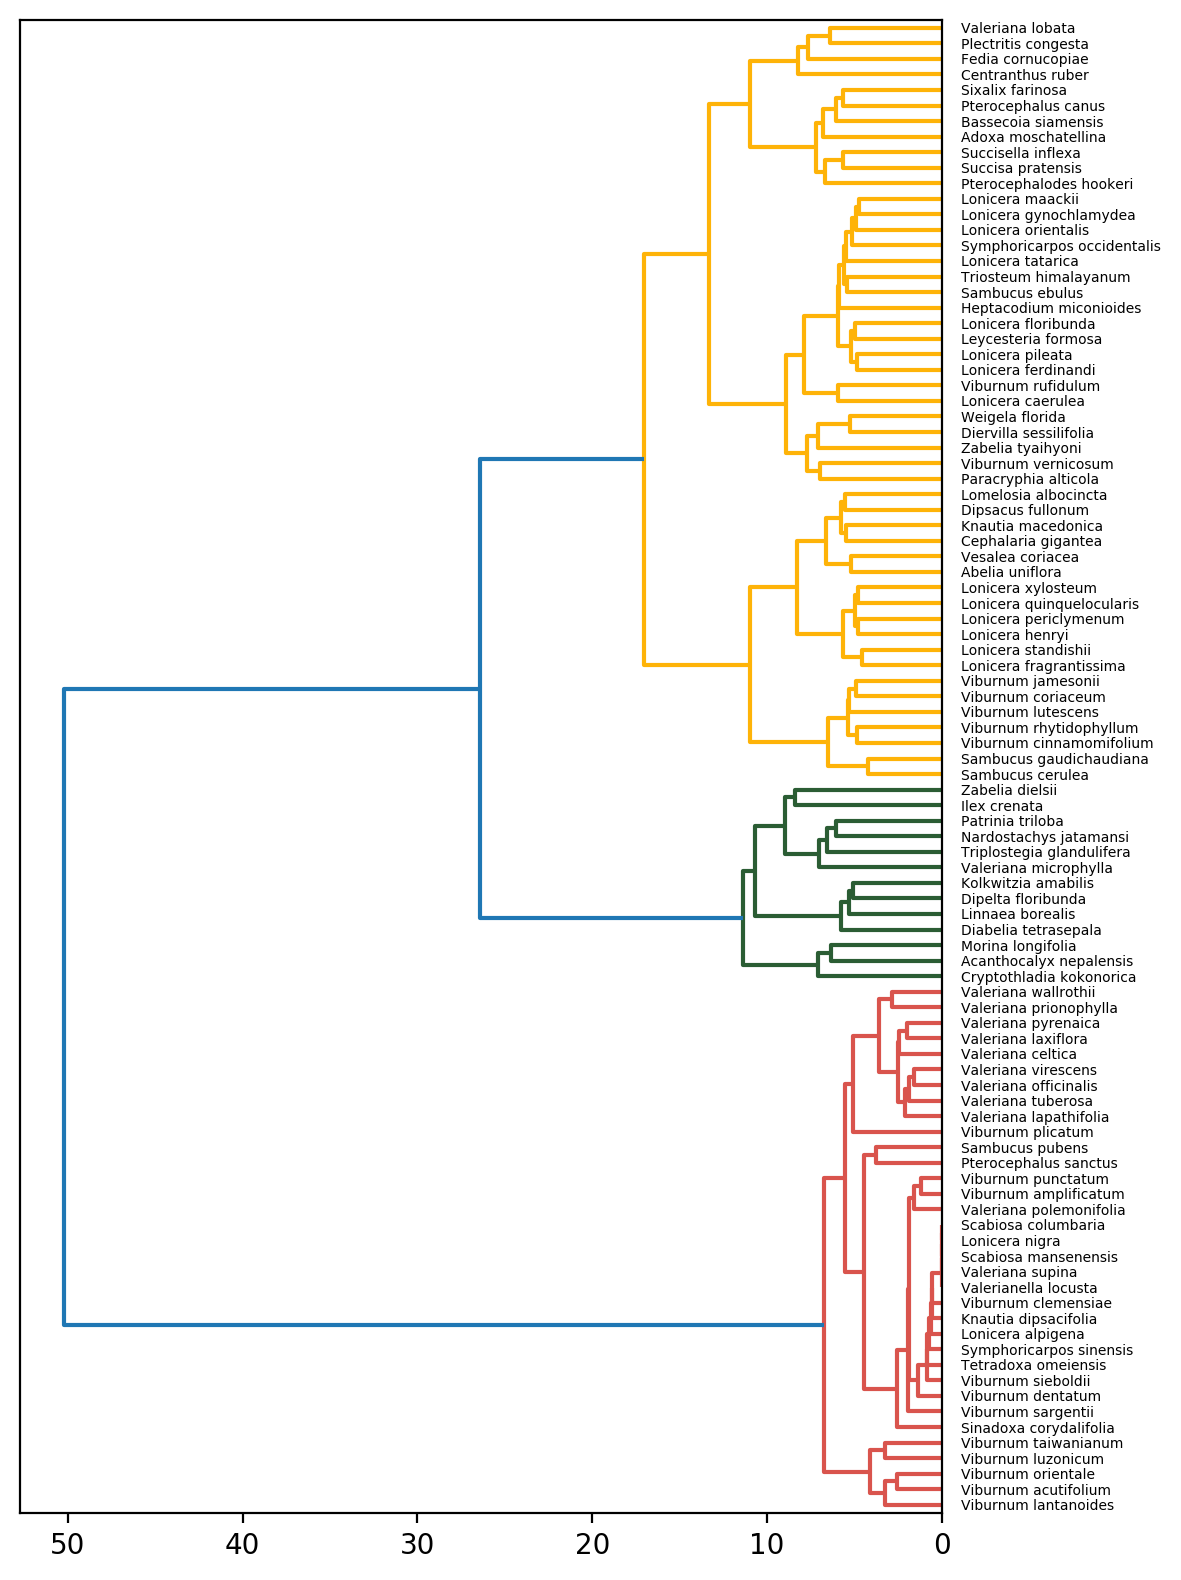

In [12]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6, 8))

cluster.hierarchy.set_link_color_palette(["xkcd:pale red", "xkcd:pine", "xkcd:amber"])
Z = cluster.hierarchy.linkage(recycled_percent_353[locus_cols], method  = "ward")
ward_dendro = cluster.hierarchy.dendrogram(Z, color_threshold=(1/2)*max(Z[:,2]),
                                           orientation="left", labels = list(recycled_percent_353.index), 
                                           ax = ax, )

plt.tight_layout()

In [13]:
recycled_percent_353 = recycled_percent_353.reindex(ward_dendro['ivl'])

Now let's grab just the loci we included in the phylogenetic analyses.

In [14]:
excluded = []
with open(Path("../Data/HybPiper/paralogs_excluded.txt"), "r") as f:
    for line in f.readlines():
        if len(line) ==5: excluded.append("locus{}".format(line.replace("\n","")))
included = [l for l in locus_cols if l not in excluded]

Now I'll reorganize the order of the loci to highlight which ones we kept for analyses. I'll start by clustering the loci by percent length.

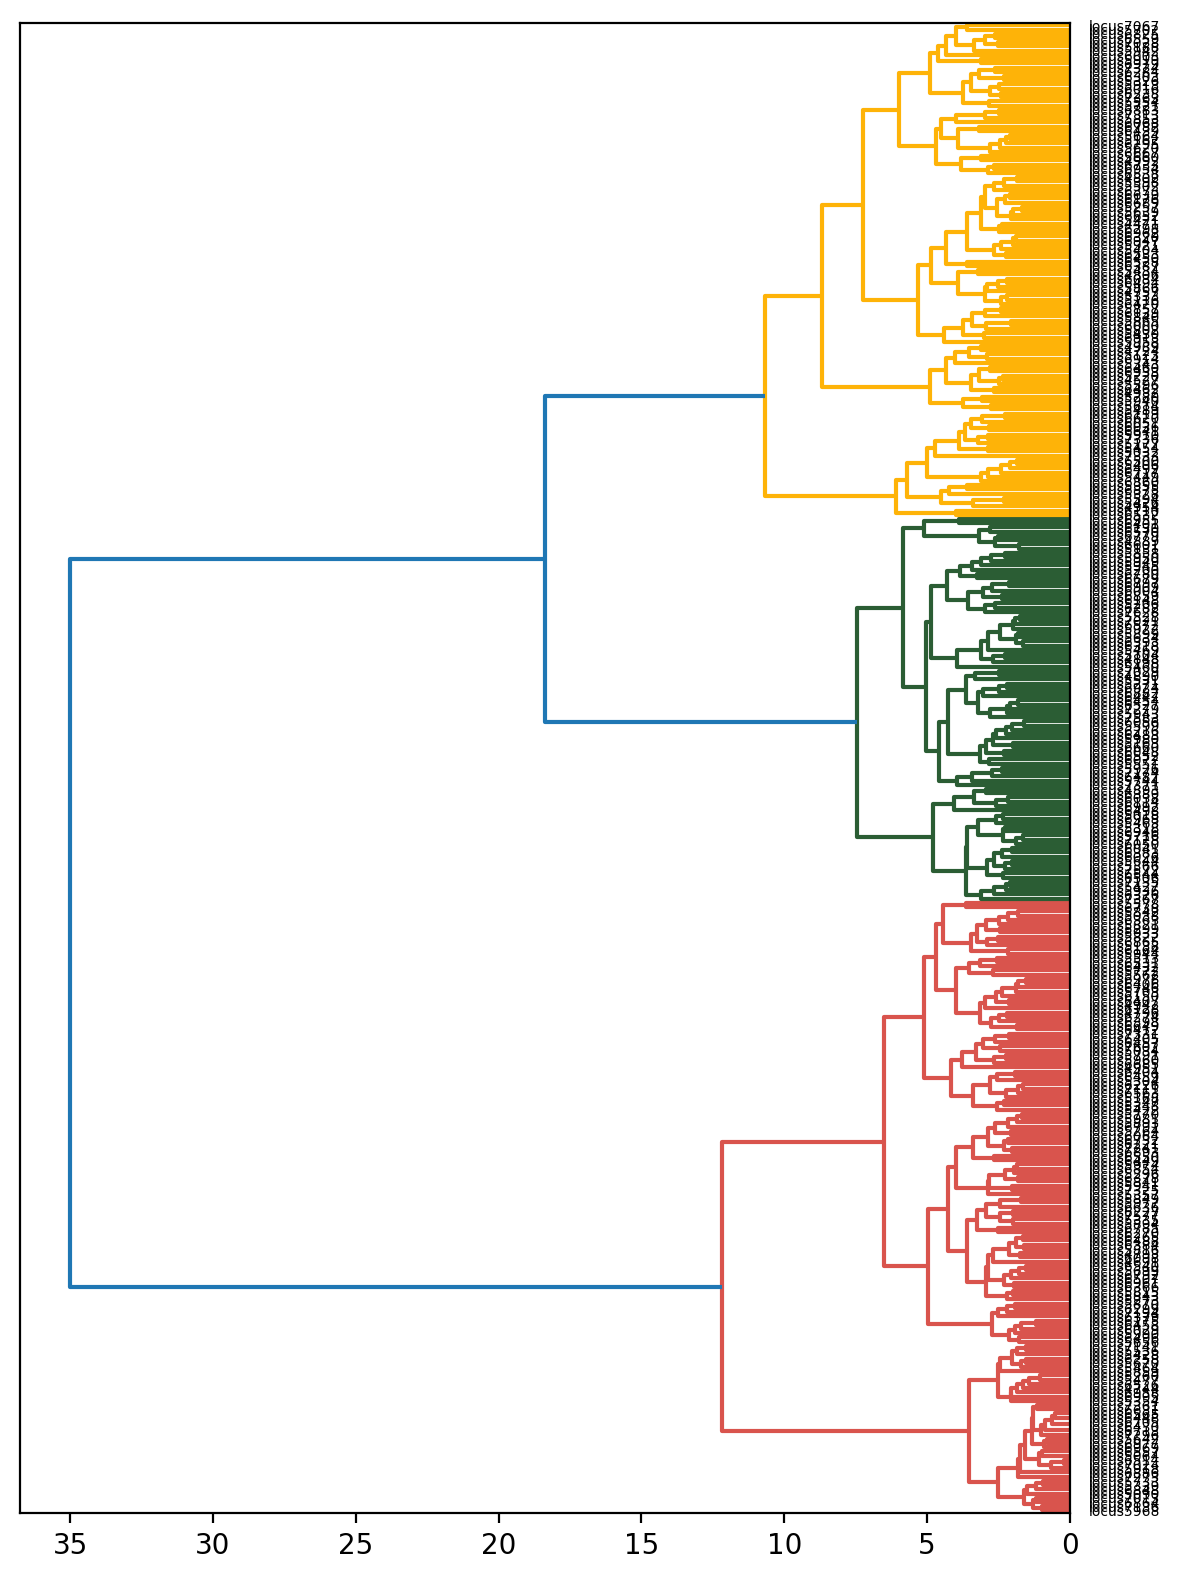

In [15]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(6, 8))

locusZ = cluster.hierarchy.linkage(recycled_percent_353[locus_cols].T, method  = "ward")
locus_ward_dendro = cluster.hierarchy.dendrogram(locusZ, color_threshold=(1/3)*max(Z[:,2]),
                                           orientation="left", labels = list(recycled_percent_353[locus_cols].T.index), 
                                           ax = ax)

plt.tight_layout()

In [16]:
percent_353 = percent_353[locus_ward_dendro['ivl']]
recycled_percent_353 = recycled_percent_353[locus_ward_dendro['ivl']]

locus_cols = [c for c in recycled_percent_353.columns if c.startswith("locus")]

**Remember** that the `labels` parameter of `cluster.hierarchy.dendrogram` should be the original order of the columns that created `Z`, which in this case are the original indices of `recycled_percent_353`, all of the species in alphabetical order.

Now I'll use a grid layout to add additional plots around the outside that show taxon and locus occupancy, which taxa were excluded from parts of analyses, and which loci were used. First I'll use the species tree to figure out which taxa in the data frame were included.

In [17]:
dips = toytree.tree("../Data/Concordance_analysis/Trees/supercontig_collapsed33.rooted.new")

In [18]:
species_tree_tips = dips.get_tip_labels()
species_tree_tips = [s.replace("_", " ") for s in species_tree_tips]
species_tree_tips[species_tree_tips.index("Acanthocalyx nepalensis ssp delevaya")] = "Acanthocalyx nepalensis"

In [19]:
in_tree = []
for i in recycled_percent_353.index:
    if i in species_tree_tips:
        in_tree.append(True)
    else:
        in_tree.append(False)
percent_353["intree"] = in_tree
recycled_percent_353["intree"] = in_tree

Now count how many taxa each locus contains, and how many loci were recovered for each taxon.

In [20]:
locus_counts = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1)
taxon_counts = 96-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=0)

recycled_locus_counts = 353-(recycled_percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1)
recycled_taxon_counts = 96-(recycled_percent_353[locus_cols] == 0.000000).astype(float).sum(axis=0)

In [21]:
medianIQR(taxon_counts)

(31.0, 48.0, 58.0)

In [22]:
medianIQR(recycled_taxon_counts)

(31.0, 47.0, 57.0)

Now reorder columns to group loci we did and didn't use.

In [23]:
locus_presence_grouping = deque()
for l in locus_cols:
    if l in included:
        locus_presence_grouping.appendleft(l)
    else:
        locus_presence_grouping.append(l)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


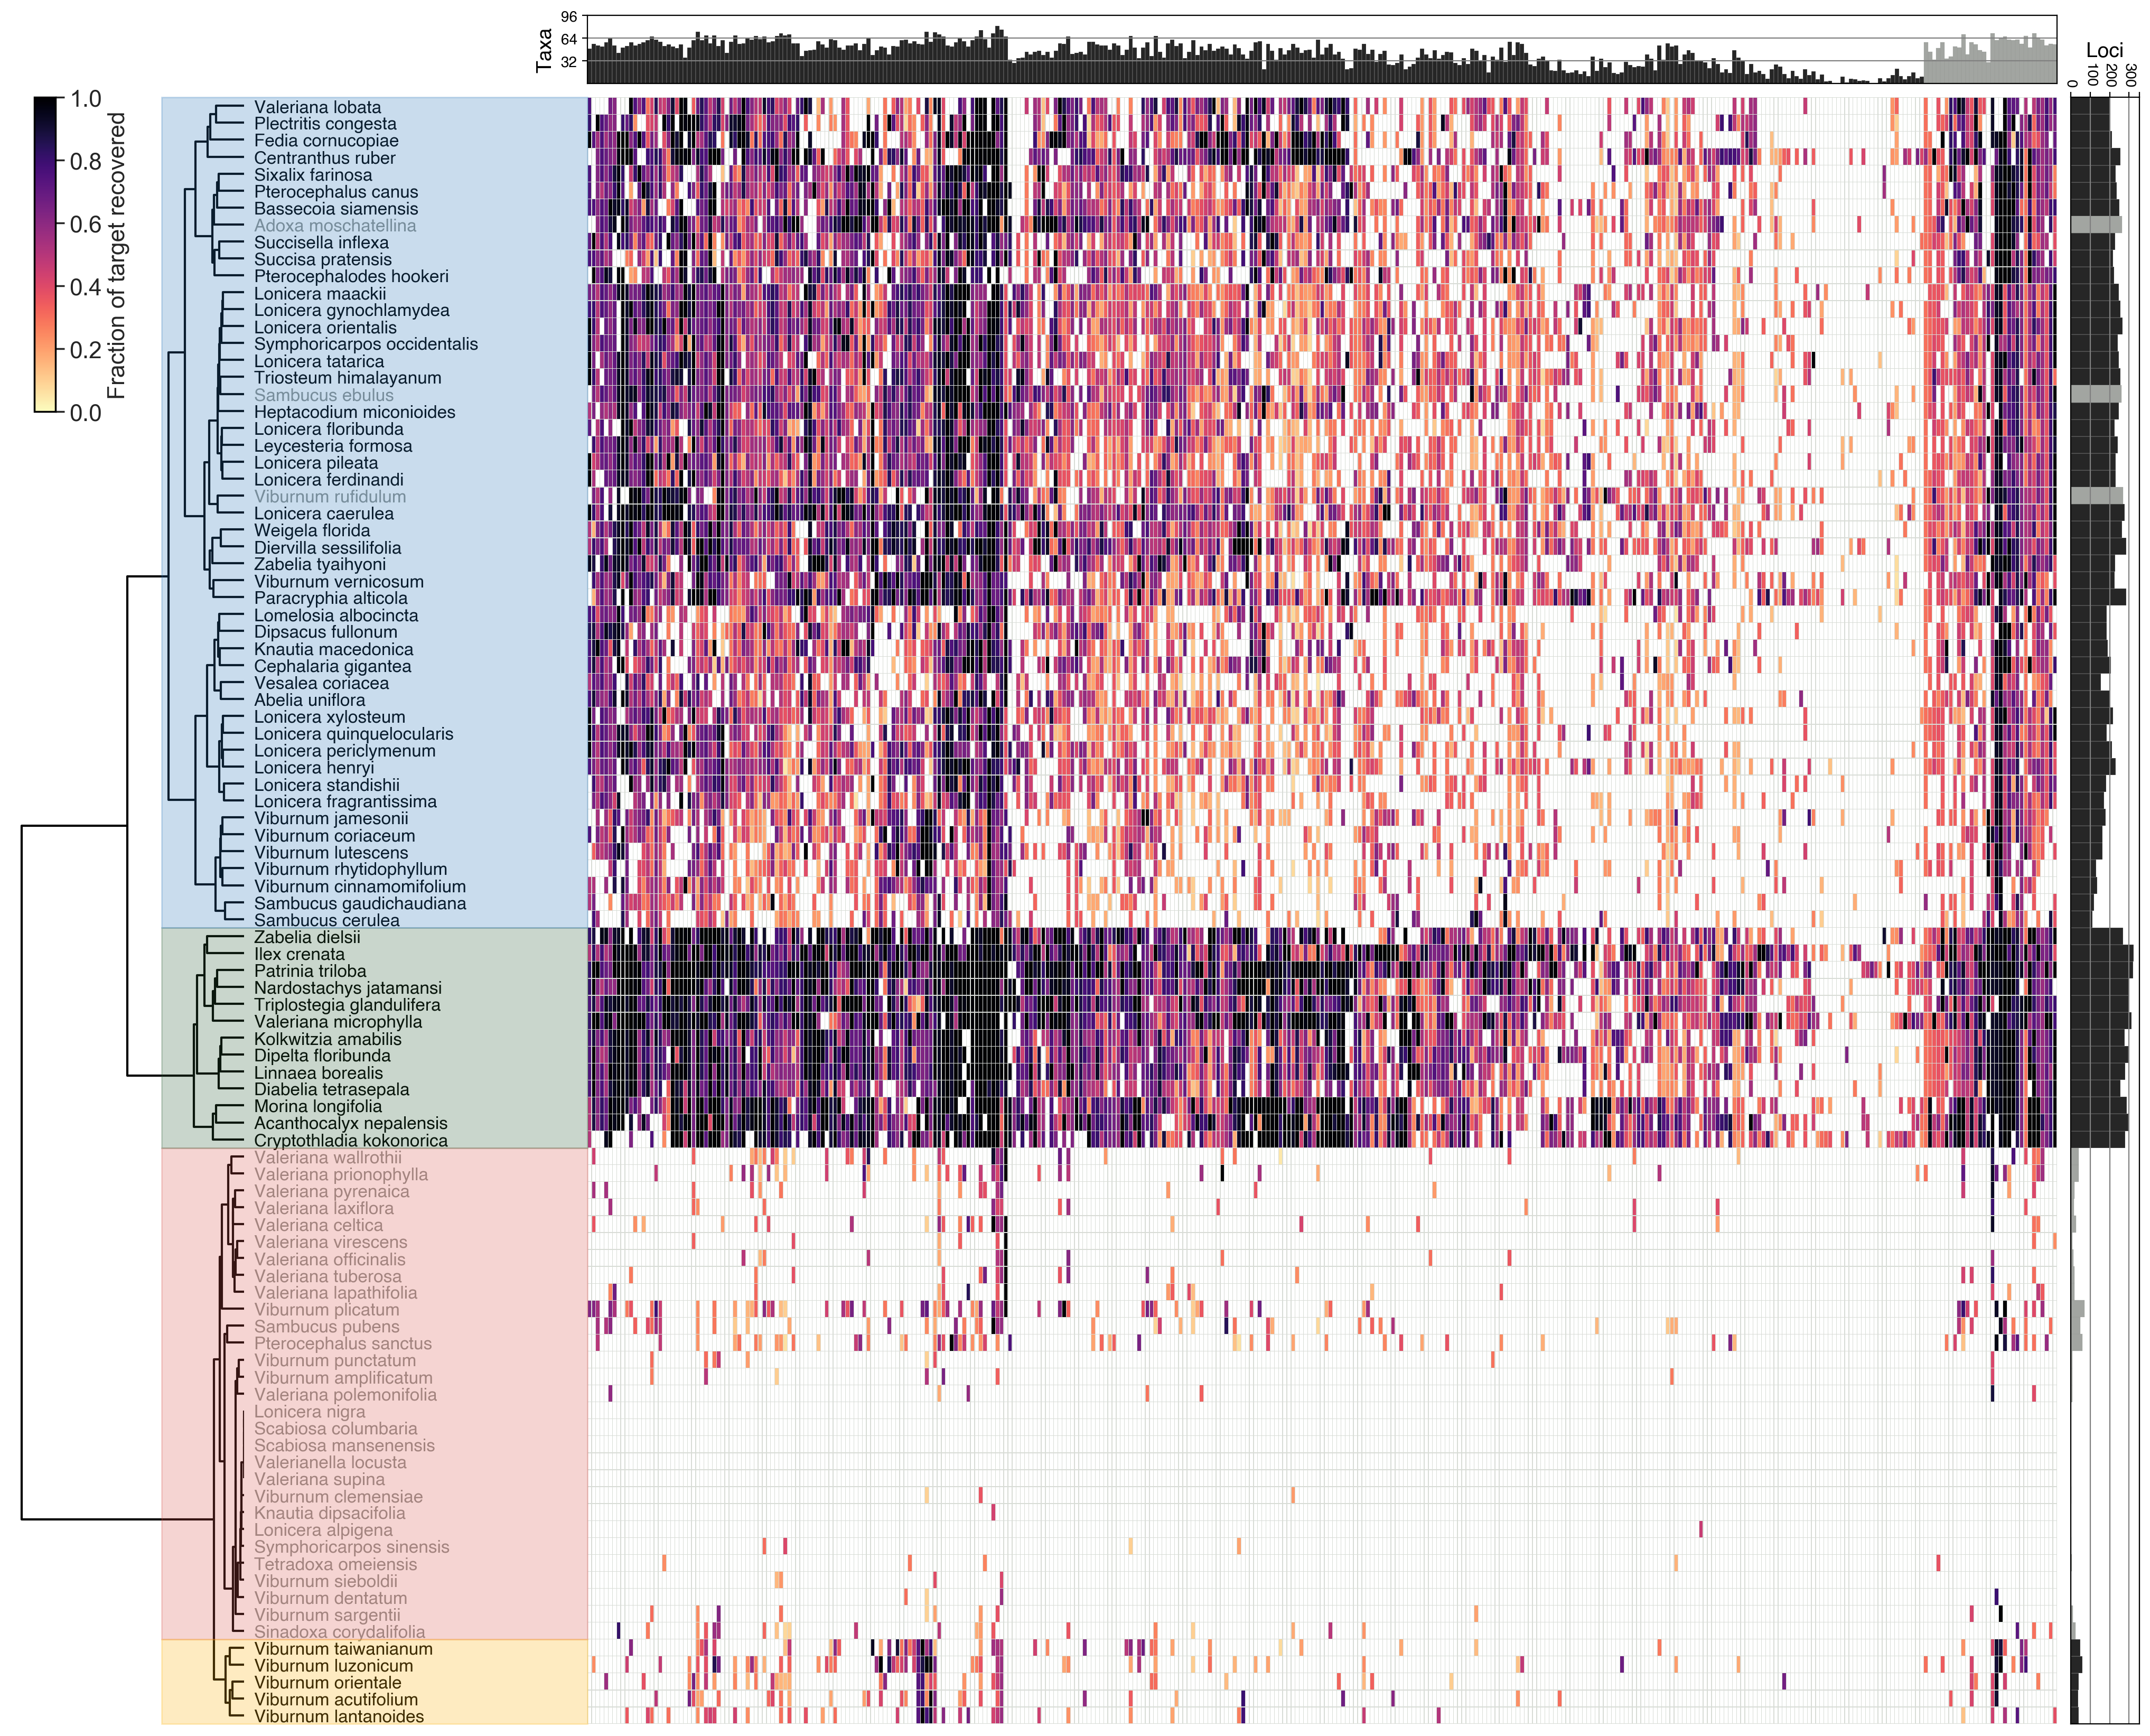

In [24]:
cluster.hierarchy.set_link_color_palette(["xkcd:pale red", "xkcd:pine", "xkcd:amber"])
Z = cluster.hierarchy.linkage(recycled_percent_353[locus_cols], method  = "ward")
ward_dendro = cluster.hierarchy.dendrogram(Z, color_threshold=(1/3)*max(Z[:,2]),
                                           orientation="left", labels = list(recycled_percent_353.index), 
                                           ax = ax, )

plt.style.use('default')
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['pdf.fonttype'] = 42
fig = plt.figure(constrained_layout=False, figsize=(26,21))

# Create grid
gs = fig.add_gridspec(21, 26)
# Add dendrogram, bar plot, and heat map axes
ax_dg = fig.add_subplot(gs[1:, :3])
ax_tp = fig.add_subplot(gs[0, 7:-1])
ax_lp = fig.add_subplot(gs[1:, -1])
ax_hm = fig.add_subplot(gs[1:, 7:-1])

# Add taxon bar chart and color by inclusion
taxon_counts = 96-(recycled_percent_353[locus_presence_grouping] == 0.000000).astype(float).sum(axis=0)
tpbar = ax_tp.bar(x=range(353), height=taxon_counts, color="xkcd:black", width=1.0, alpha=0.85, 
          edgecolor="white", linewidth=0.10, align='edge')
counts=0
for i, locus in enumerate(recycled_percent_353[locus_presence_grouping].columns):
    if locus not in included: tpbar[i].set_color('xkcd:grey')
    else:counts+=1
# Add locus bar chart
lpbar = ax_lp.barh(y=range(96), width=recycled_locus_counts, color="xkcd:black", height=1.0, alpha=0.85, 
               align='edge',  edgecolor="white", linewidth=0.10)

ax_tp.set_xticks([])
ax_tp.set_xticklabels([])
ax_tp.set_yticks([32, 64, 96])
ax_tp.set_yticklabels([32, 64, 96])
ax_tp.set_xlim(0, 353)
ax_tp.set_ylim(0, 96)
ax_tp.grid(axis="y", color="gray")
ax_tp.set_ylabel("Taxa", size=14)

ax_lp.xaxis.tick_top()
ax_lp.xaxis.set_label_position("top")
ax_lp.set_yticks([])
ax_lp.set_yticklabels([])
ax_lp.set_xlim(0, 353)
ax_lp.set_ylim(0, 96)
ax_lp.set_xticks([0,100, 200, 300, 353])
ax_lp.set_xticklabels([0, 100, 200, 300], rotation=-90)
ax_lp.grid(axis="x", color="gray")
ax_lp.set_xlabel("Loci", size=14)

# Add cluster background colors
patchx0, patchy0 = (0.18, ax_dg.get_position().get_points()[0,1])
patchwidth = ax_hm.get_position().get_points()[0,0]-patchx0
yellowheight = ((ax_hm.get_position().get_points()[1,1] - ax_hm.get_position().get_points()[0,1])/96)*5
yellowpatch = plt.Rectangle((patchx0, patchy0), patchwidth, yellowheight, edgecolor=None,
                        fill=True, color='xkcd:amber', alpha=0.25, zorder=1000, transform=fig.transFigure, figure=fig)
redheight = ((ax_hm.get_position().get_points()[1,1] - ax_hm.get_position().get_points()[0,1])/96)*29
redpatch = plt.Rectangle((patchx0, patchy0+yellowheight), patchwidth, redheight, fill=True, color='xkcd:pale red', 
                            alpha=0.25, zorder=1000, transform=fig.transFigure, figure=fig)
greenheight = ((ax_hm.get_position().get_points()[1,1] - ax_hm.get_position().get_points()[0,1])/96)*(13)
greenpatch = plt.Rectangle((patchx0, patchy0+redheight+yellowheight), patchwidth, greenheight, fill=True, color='xkcd:pine', 
                            alpha=0.25, zorder=1000, transform=fig.transFigure, figure=fig)
blueheight = ((ax_hm.get_position().get_points()[1,1] - ax_hm.get_position().get_points()[0,1])/96)*(96-5-29-13)
bluepatch = plt.Rectangle((patchx0, patchy0+redheight+yellowheight+greenheight), patchwidth, blueheight, fill=True, color='xkcd:bluish', 
                            alpha=0.25, zorder=1000, transform=fig.transFigure, figure=fig)

fig.patches.extend([redpatch, yellowpatch, greenpatch, bluepatch])

# Add dendrogram and color labels by inclusion
cluster.hierarchy.set_link_color_palette(["black", "black", "black"])
cluster.hierarchy.dendrogram(Z, color_threshold=(1/2)*max(Z[:,2]), orientation="left", 
                             leaf_font_size=12, ax=ax_dg, labels=ward_dendro['ivl'],
                             above_threshold_color="black", )

for i, lbl in enumerate(ax_dg.get_ymajorticklabels()):
    if not recycled_percent_353.loc[lbl.get_text(), "intree"]:
        lbl.set_color("xkcd:grey")
        lpbar[i].set_color('xkcd:grey')
        
ax_dg.grid(False)
ax_dg.set_facecolor('white')
ax_dg.set_xticks([])
ax_dg.set_xticklabels([])
for s in ['right', 'left', 'top', 'bottom']:
    ax_dg.spines[s].set_visible(False)

# Add heat map
sns.set(font_scale=1)
mask = recycled_percent_353[locus_presence_grouping].isnull()
heatmap = sns.heatmap(data=recycled_percent_353[locus_presence_grouping].replace(to_replace=0, value=np.nan), 
                      linecolor="xkcd:light grey", mask=mask, cmap='magma_r', vmin=0.0, vmax=1.0, 
                      linewidths=0.10, ax=ax_hm, cbar=False,
            cbar_kws = {"ticks":np.linspace(start=0.0, stop = 1.0, num=11), "shrink": 0.50})

ax_hm.set_facecolor('white')
ax_hm.set_ylim([0, 96])
ax_hm.set_xticks([])
ax_hm.set_xticklabels([])
ax_hm.set_yticklabels([])
ax_hm.axis('off')

ax_hm.set_xlabel("Locus", size=20)
ax_hm.set_ylabel("")

# Add color bar
cmap = plt.cm.magma_r
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
cax = fig.add_subplot(gs[1:5, 0])
cbar = colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cbar.ax.set_aspect(15)
cbar.outline.set_edgecolor('black')
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Fraction of target recovered", size=16)

plt.tight_layout()
# plt.savefig('../Figures/Statistics/Figure_2.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')

## Global and cluster-based statistics
First let's see what the median number of loci recovered and median lengths are for the dataset as a whole. I'll also look at the mean maximum length.

In [25]:
global_median = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).median()
global_lower = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).describe()["75%"]
global_upper = 353-(percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).describe()["25%"]

global_median_len = percent_353[locus_cols].replace(0.0, np.nan).median().median()
global_median_lower = percent_353[locus_cols].replace(0.0, np.nan).median().describe()["25%"]
global_median_upper = percent_353[locus_cols].replace(0.0, np.nan).median().describe()["75%"]

global_max_len = percent_353[locus_cols].replace(0.0, np.nan).max().median()
global_max_lower = percent_353[locus_cols].replace(0.0, np.nan).max().describe()["25%"]
global_max_upper = percent_353[locus_cols].replace(0.0, np.nan).max().describe()["75%"]

print("The global median loci recovered was {:2.0f} (IQR: {:2.0f}-{:2.0f})".format(global_median, 
                                                                                 global_lower,
                                                                                 global_upper))

print("The global median length recovered was {:3.1%} (IQR {:3.1%}-{:3.1%}) the expected exon length".format(global_median_len, 
                                                                                                             global_median_lower,
                                                                                                             global_median_upper))
print("The global median maximum length recovered was {:3.1%} (IQR {:3.1%}-{:3.1%}) the expected exon length".format(
                                                                                                             global_max_len, 
                                                                                                             global_max_lower,
                                                                                                             global_max_upper))

The global median loci recovered was 190 (IQR: 34-250)
The global median length recovered was 44.8% (IQR 33.5%-58.4%) the expected exon length
The global median maximum length recovered was 96.6% (IQR 84.6%-103.0%) the expected exon length


/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [26]:
global_median = 353-(recycled_percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).median()
global_lower = 353-(recycled_percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).describe()["75%"]
global_upper = 353-(recycled_percent_353[locus_cols] == 0.000000).astype(float).sum(axis=1).describe()["25%"]

global_median_len = recycled_percent_353[locus_cols].replace(0.0, np.nan).median().median()
global_median_lower = recycled_percent_353[locus_cols].replace(0.0, np.nan).median().describe()["25%"]
global_median_upper = recycled_percent_353[locus_cols].replace(0.0, np.nan).median().describe()["75%"]

global_max_len = recycled_percent_353[locus_cols].replace(0.0, np.nan).max().median()
global_max_lower = recycled_percent_353[locus_cols].replace(0.0, np.nan).max().describe()["25%"]
global_max_upper = recycled_percent_353[locus_cols].replace(0.0, np.nan).max().describe()["75%"]

print("The global median loci recovered was {:2.0f} (IQR: {:2.0f}-{:2.0f})".format(global_median, 
                                                                                 global_lower,
                                                                                 global_upper))

print("The global median length recovered was {:3.1%} (IQR {:3.1%}-{:3.1%}) the expected exon length".format(global_median_len, 
                                                                                                             global_median_lower,
                                                                                                             global_median_upper))
print("The global median maximum length recovered was {:3.1%} (IQR {:3.1%}-{:3.1%}) the expected exon length".format(
                                                                                                             global_max_len, 
                                                                                                             global_max_lower,
                                                                                                             global_max_upper))

The global median loci recovered was 197 (IQR: 35-252)
The global median length recovered was 49.8% (IQR 38.2%-63.6%) the expected exon length
The global median maximum length recovered was 106.0% (IQR 91.6%-116.1%) the expected exon length


In [27]:
recycled_percent_353["cluster"] = np.concatenate((np.repeat("low", 34), np.repeat("acceptable",0), np.repeat("high", 13), np.repeat("moderate", 49)))
by_cluster = recycled_percent_353.groupby("cluster")

In [28]:
for g in by_cluster.groups:
    median_len = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).median()
    len_lower = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).describe()["25%"]
    len_upper = by_cluster.get_group(g).replace(0, np.nan).median(axis=0).describe()["75%"]

    
    temp = by_cluster.get_group(g)[locus_cols]
    rec_median = 353-(temp == 0.000000).astype(float).sum(axis=1).median()
    rec_lower = 353-(temp == 0.000000).astype(float).sum(axis=1).describe()["75%"]
    rec_upper = 353-(temp == 0.000000).astype(float).sum(axis=1).describe()["25%"]
    
    print("{} median loci recovered {:2.0f} (IQR: {:2.0f}-{:2.0f})".format(g, rec_median, rec_lower, rec_upper))
    print("{} median length {:2.1%} (IQR: {:2.1%}-{:2.1%})\n".format(g, median_len, len_lower, len_upper))

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


high median loci recovered 295 (IQR: 279-301)
high median length 70.4% (IQR: 53.1%-87.7%)

low median loci recovered 12 (IQR:  4-40)
low median length 34.1% (IQR: 24.8%-48.3%)

moderate median loci recovered 225 (IQR: 186-248)
moderate median length 44.7% (IQR: 34.3%-61.2%)



## Locus-based statistics
The next set of analyses look at the number locus that have certain properties or meet a filtering criterion.

In [29]:
revisedStats = Path("../Data/HybPiper/hybpiper_stats_FIRST.txt")
recycledStats = Path("../Data/HybPiper/hybpiper_stats_SECOND.txt")

raw_stats = pd.read_csv(revisedStats, sep='\t', index_col=0)
raw_stats.index = [s.replace("_", " ") for s in raw_stats.index]

recycled_stats = pd.read_csv(recycledStats, sep='\t', index_col=0)
recycled_stats.index = [s.replace("_", " ") for s in recycled_stats.index]

raw_stats = raw_stats.sort_index()
recycled_stats = recycled_stats.sort_index()

recycled_stats.head()

NumReads  ReadsMapped  PctOnTarget  GenesMapped  \
Abelia uniflora            711770       149705        0.210          349   
Acanthocalyx nepalensis    873917       368322        0.421          352   
Adoxa moschatellina       1020114       169532        0.166          349   
Bassecoia siamensis        594894       142702        0.240          347   
Centranthus ruber          321136       103081        0.321          344   

                         GenesWithContigs  GenesWithSeqs  GenesAt25pct  \
Abelia uniflora                       219            203           172   
Acanthocalyx nepalensis               325            308           286   
Adoxa moschatellina                   296            280           242   
Bassecoia siamensis                   271            257           228   
Centranthus ruber                     295            282           241   

                         GenesAt50pct  GenesAt75pct  Genesat150pct  \
Abelia uniflora                    83            28              0   
Acanthocalyx nepalensis           230           156              0   
Adoxa moschatellina               172            99              0   
Bassecoia siamensis               131            64              0   
Centranthus ruber                 187           106              0   

                         ParalogWarnings  
Abelia uniflora                        1  
Acanthocalyx nepalensis              108  
Adoxa moschatellina                   23  
Bassecoia siamensis                   14  
Centranthus ruber                     89

In [30]:
recycled_stats.sort_values("ParalogWarnings", ascending=False)[:20]["ParalogWarnings"]

Cryptothladia kokonorica    134
Morina longifolia           112
Acanthocalyx nepalensis     108
Centranthus ruber            89
Zabelia dielsii              86
Viburnum rufidulum           44
Fedia cornucopiae            43
Pterocephalodes hookeri      35
Valeriana lobata             31
Lonicera caerulea            27
Adoxa moschatellina          23
Paracryphia alticola         22
Zabelia tyaihyoni            22
Ilex crenata                 18
Diervilla sessilifolia       14
Succisa pratensis            14
Bassecoia siamensis          14
Plectritis congesta          14
Valeriana microphylla        12
Nardostachys jatamansi       11
Name: ParalogWarnings, dtype: int64

In [31]:
dipsacales_stats = raw_stats.reset_index()
dipsacales_stats.rename({"index":"species"}, axis=1, inplace=True)
dipsacales_stats = dipsacales_stats.merge(raw_353[[c for c in raw_353.columns if not c.startswith("locus")]], on="species")
dipsacales_stats["round"] = "first"

recycled_dipsacales_stats = recycled_stats.reset_index()
recycled_dipsacales_stats.rename({"index":"species"}, axis=1, inplace=True)
recycled_dipsacales_stats = recycled_dipsacales_stats.merge(recycled_353[[c for c in recycled_353.columns if not c.startswith("locus")]], on="species")
recycled_dipsacales_stats["round"] = "second"
recycled_dipsacales_stats.head()

species  NumReads  ReadsMapped  PctOnTarget  GenesMapped  \
0          Abelia uniflora    711770       149705        0.210          349   
1  Acanthocalyx nepalensis    873917       368322        0.421          352   
2      Adoxa moschatellina   1020114       169532        0.166          349   
3      Bassecoia siamensis    594894       142702        0.240          347   
4        Centranthus ruber    321136       103081        0.321          344   

   GenesWithContigs  GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  \
0               219            203           172            83            28   
1               325            308           286           230           156   
2               296            280           242           172            99   
3               271            257           228           131            64   
4               295            282           241           187           106   

   Genesat150pct  ParalogWarnings  initial_concentration  initial_ng_DNA  \
0              0                1                    4.3          225.75   
1              0              108                   95.0         9500.00   
2              0               23                  101.0        43430.00   
3              0               14                    2.6           26.00   
4              0               89                   11.6          754.00   

          genus  cycles  post_amp_ng_DNA  pool   round  
0        Abelia      12            197.6     6  second  
1  Acanthocalyx      12            934.8     8  second  
2         Adoxa      12           1615.0     4  second  
3     Bassecoia      16            207.1     8  second  
4   Centranthus      12           1976.0     8  second

Pull out taxa with no sequences

In [32]:
recycled_dipsacales_stats[recycled_dipsacales_stats["GenesWithSeqs"]==0]

species  NumReads  ReadsMapped  PctOnTarget  GenesMapped  \
28        Lonicera nigra      2877          608        0.211           70   
49  Scabiosa mansenensis      3288          572        0.174           70   
68      Valeriana supina     39172          214        0.005           29   
72  Valerianella locusta     14777          900        0.061          143   

    GenesWithContigs  GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  \
28                 4              0             0             0             0   
49                 3              0             0             0             0   
68                 1              0             0             0             0   
72                 4              0             0             0             0   

    Genesat150pct  ParalogWarnings  initial_concentration  initial_ng_DNA  \
28              0                0                   20.2          2020.0   
49              0                0                  101.0         43430.0   
68              0                0                   27.0          4050.0   
72              0                0                   11.5           460.0   

        genus  cycles  post_amp_ng_DNA  pool   round  
28   Lonicera      12            969.0     5  second  
49    Sixalix      12            649.8     7  second  
68  Valeriana      12           1269.2     2  second  
72   Viburnum      12           1345.2     8  second

In [33]:
fused = pd.concat([dipsacales_stats, recycled_dipsacales_stats], axis=0)
fused["all"] = ""

In [34]:
numeric_stats = dipsacales_stats[[c for c in dipsacales_stats.columns if dipsacales_stats[c].dtype.kind in 'biufc']]
recycled_numeric_stats = recycled_dipsacales_stats[[c for c in recycled_dipsacales_stats.columns if recycled_dipsacales_stats[c].dtype.kind in 'biufc']]
recycled_numeric_stats.head()

NumReads  ReadsMapped  PctOnTarget  GenesMapped  GenesWithContigs  \
0    711770       149705        0.210          349               219   
1    873917       368322        0.421          352               325   
2   1020114       169532        0.166          349               296   
3    594894       142702        0.240          347               271   
4    321136       103081        0.321          344               295   

   GenesWithSeqs  GenesAt25pct  GenesAt50pct  GenesAt75pct  Genesat150pct  \
0            203           172            83            28              0   
1            308           286           230           156              0   
2            280           242           172            99              0   
3            257           228           131            64              0   
4            282           241           187           106              0   

   ParalogWarnings  initial_concentration  initial_ng_DNA  cycles  \
0                1                    4.3          225.75      12   
1              108                   95.0         9500.00      12   
2               23                  101.0        43430.00      12   
3               14                    2.6           26.00      16   
4               89                   11.6          754.00      12   

   post_amp_ng_DNA  pool  
0            197.6     6  
1            934.8     8  
2           1615.0     4  
3            207.1     8  
4           1976.0     8

In [35]:
name_display_dict = {'NumReads':"Total reads", 
                     'ReadsMapped':"Reads mapped", 
                     'PctOnTarget':"Fraction on target", 
                     'GenesMapped':"Loci mapped",
                     'GenesWithContigs':"Loci with contigs", 
                     'GenesWithSeqs':"Loci with sequences", 
                     'GenesAt25pct':"Loci $\geq$ 25% total length", 
                     'GenesAt50pct':"Loci $\geq$ 50% total length",
                     'GenesAt75pct':"Loci $\geq$ 75% total length", 
                     'ParalogWarnings':"Paralog warnings per sample", 
                     'initial_concentration':"Initial sample\nconcentration (ng/$\mu$g)",
                     'initial_ng_DNA':"Initial sample DNA (ng)", 
                     'cycles':"Library PCR cycles", 
                     'post_amp_ng_DNA':"Post-amplification\nsample DNA (ng)", 
                     'pool':"Library pool"}

In [36]:
tcdf = pd.DataFrame([np.concatenate([taxon_counts,recycled_taxon_counts]),
              np.concatenate([np.repeat("first",len(taxon_counts)), np.repeat("second",len(taxon_counts))]),
              np.repeat("",len(taxon_counts)*2)]).T
tcdf.columns = ["taxoncount", "round", "all"]
tcdf["taxoncount"] = tcdf.taxoncount.astype(int)
tcdf.head()

taxoncount  round all
0          49  first    
1          56  first    
2          54  first    
3          52  first    
4          58  first

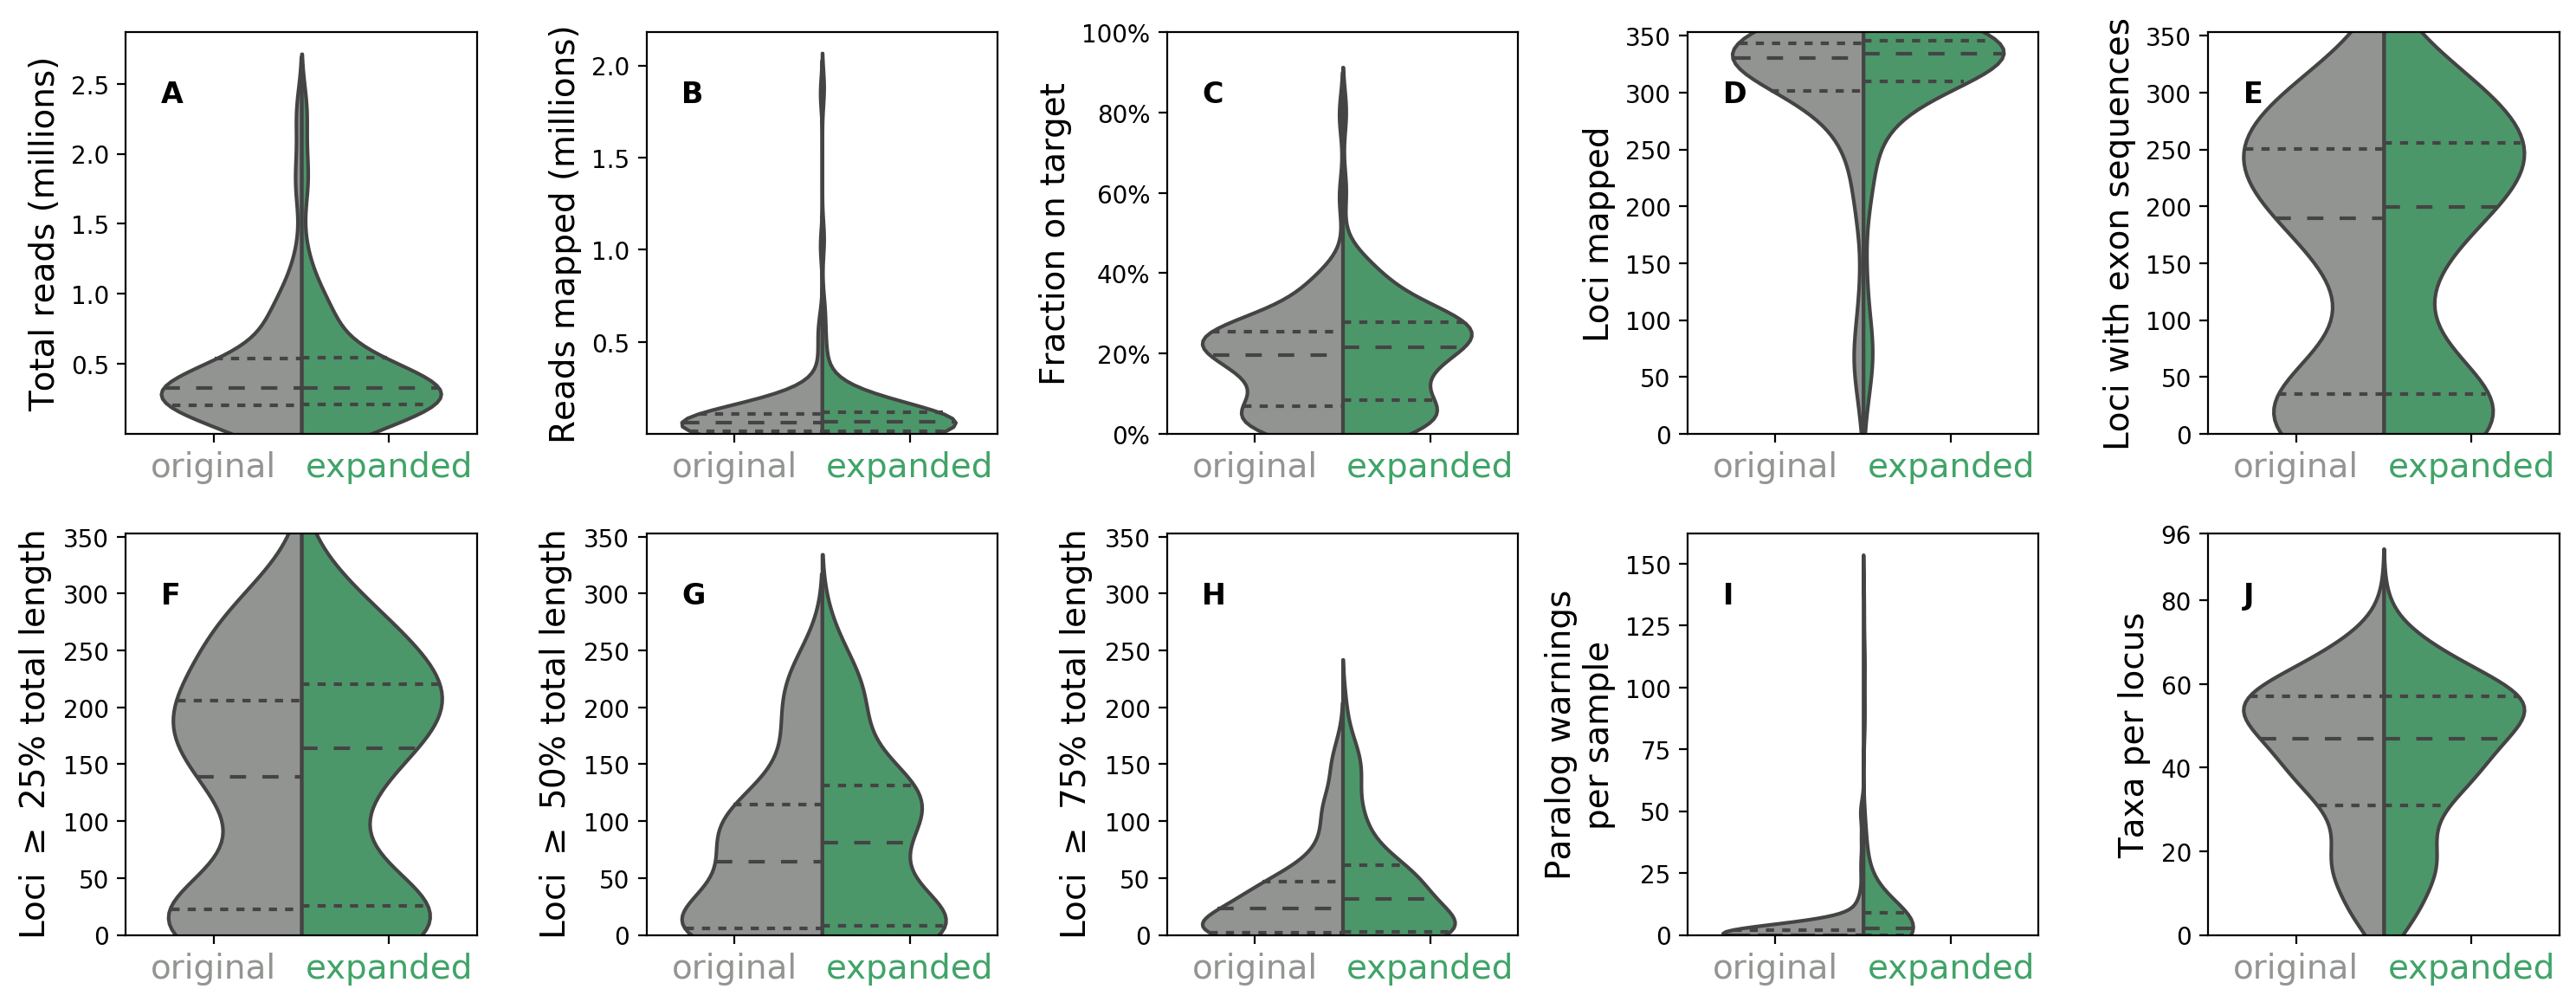

In [37]:
nrows = 2
ncols = 5

plt.style.use('default')
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))

j = 0
for i, col in enumerate(recycled_numeric_stats.columns):
    if col in ["pool", "Genesat150pct", "genus_factor", "cycles", "initial_ng_DNA", 
               "post_amp_ng_DNA", "initial_concentration", "GenesWithContigs"]:
        continue
    else:
        ax = axs.reshape(-1)[j]
        
        sns.violinplot(x="all", y=col, data=fused, hue="round", inner='quartile', split=True,
                       orient="v", ax = axs.reshape(-1)[j], palette=sns.color_palette(["xkcd:gray", "xkcd:greenish"]))

        if ax.get_ylim()[0] < 0:
            ax.set_ylim([0, ax.get_ylim()[1]])       

        if "GENES" in col.upper():
            ax.set_ylim([0, 353])
            
        if col.lower() == "numreads":
            ax.set_ylabel("Total reads (millions)", size=14)
        
        if col.lower() == "readsmapped":
            ax.set_ylabel("Reads mapped (millions)", size=14)
            
        if col.lower() == "pctontarget":
            ax.set_ylabel("Fraction on target", size=14)
            ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
            ax.set_yticklabels(["{}%".format(n) for n in [0, 20, 40, 60, 80, 100]])
        
        if col.lower() == "genesmapped":
            ax.set_ylabel("Loci mapped", size=14)
        
        if col.lower() == "geneswithcontigs":
            ax.set_ylabel("Loci with contigs", size=14)
        
        if col.lower() == "geneswithseqs":
            ax.set_ylabel("Loci with exon sequences", size=14)
            
        if col.upper().startswith("GENESAT"):
            ax.set_ylabel("Loci $\geq$ {}% total length".format(re.search("[\d]+", col)[0]), size=14)
            
        if col.lower() == "paralogwarnings":
            ax.set_ylabel("Paralog warnings\nper sample", size=14)
        
        ax.set_xticks([])
        ax.set_xticklabels([""])

        j+=1


sns.violinplot(x="all", y="taxoncount", data=tcdf, hue="round", inner='quartile', split=True,
                       orient="v", ax = axs[1,4], palette=sns.color_palette(["xkcd:gray", "xkcd:greenish"]))

for ax in axs.flatten():
    ax.get_legend().remove()
    ax.set_xticks([-0.25,0.25])
    ax.set_xticklabels(["original", "expanded"], size=14)
    ax.get_xticklabels()[0].set_color("xkcd:gray")
    ax.get_xticklabels()[1].set_color("xkcd:greenish")
    ax.set_xlabel("")

axs[0,0].set_yticks([0.5e6,1.0e6,1.5e6,2.0e6,2.5e6])
axs[0,0].set_yticklabels([0.5,1.0,1.5,2.0,2.5])
axs[0,1].set_yticks([0.5e6,1.0e6,1.5e6,2.0e6])
axs[0,1].set_yticklabels([0.5,1.0,1.5,2.0])
axs[1,4].set_ylim(0,96)
axs[1,4].set_yticks([0,20,40,60,80,96])
axs[1,4].set_yticklabels([0,20,40,60,80,96])
axs[1,4].set_ylabel("Taxa per locus", size=14)

for i, ax in enumerate(axs.flatten()):
    ax.annotate(string.ascii_uppercase[i], xy=(0.1, 0.825), xycoords="axes fraction", 
                    weight='bold', size=12)
# fig.delaxes(axs.reshape(-1)[-1])
    
plt.tight_layout()
# plt.savefig('../Figures/Statistics/Appendix_S4.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')

Was there a significant difference in using the expanded targets?

In [38]:
normal_test(fused["ReadsMapped"], alpha=0.01, log=True)
stats.kruskal(np.log10(fused[fused["round"]=="first"]["ReadsMapped"]),
              np.log10(fused[fused["round"]=="second"]["ReadsMapped"]))

p = 1.46612e-05
The null hypothesis can be rejected. Data are not-normal.


KruskalResult(statistic=0.5831444300517887, pvalue=0.44508243743893694)

In [39]:
normal_test(fused["PctOnTarget"], alpha=0.01, log=False)
stats.kruskal(fused[fused["round"]=="first"]["PctOnTarget"],
              fused[fused["round"]=="second"]["PctOnTarget"])

p = 4.95723e-11
The null hypothesis can be rejected. Data are not-normal.


KruskalResult(statistic=1.905966459509933, pvalue=0.16741200004796597)

In [40]:
normal_test(fused["GenesWithSeqs"], alpha=0.01, log=False)
stats.kruskal(fused[fused["round"]=="first"]["GenesWithSeqs"],
              fused[fused["round"]=="second"]["GenesWithSeqs"])

p = 0
The null hypothesis can be rejected. Data are not-normal.


KruskalResult(statistic=0.03897538340314046, pvalue=0.8434974391060953)

No, there was no significant improvement in the data, however there was an absolute improvement. Whether or not the distribution budged is one thing, but every extra locus counts, and the recycling strategy did pull a bit more out.

Now let's see if there are any correlations among variables, and dig into those that might associations with one another or have effects on the final data set size.

In [41]:
numeric_stats = numeric_stats.drop(labels=["Genesat150pct"], axis=1)

In [42]:
corrmat = numeric_stats.corr()

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


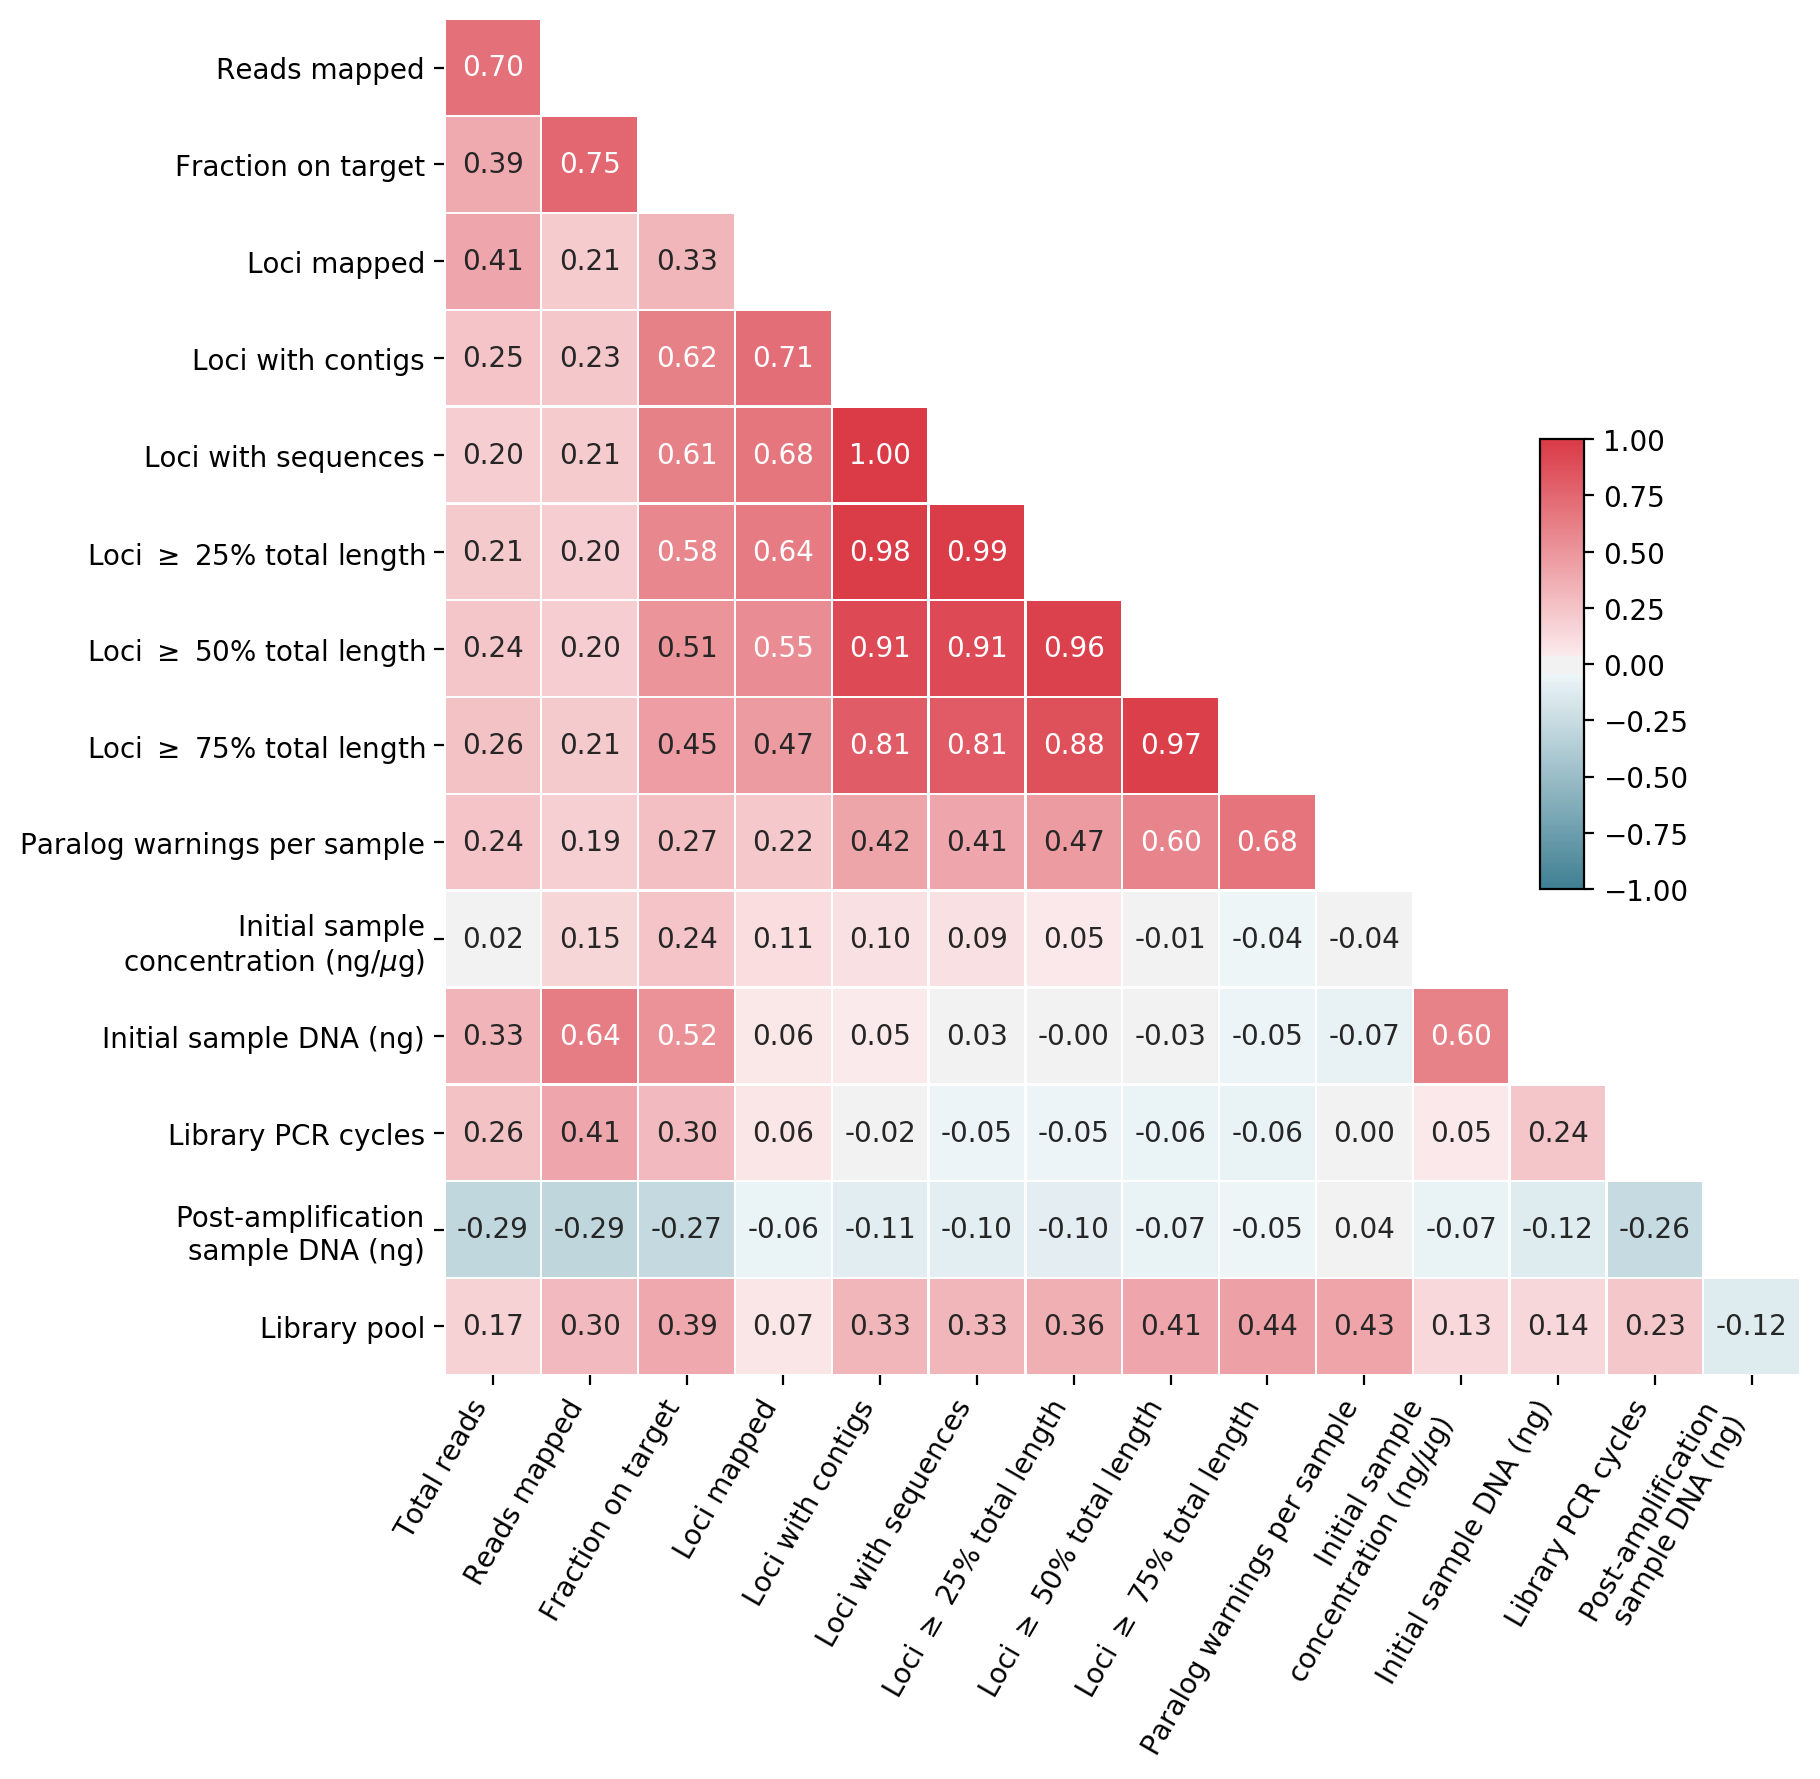

In [43]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)

sns.heatmap(corrmat, mask=mask, cmap=cmap, vmin=-1.0, vmax=1.0, center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5}, annot=True, fmt=".2f", cbar=False)

ax.set_xticks(np.linspace(start=0.5, stop=13.5, num=14))
ax.set_yticks(np.linspace(start=0.5, stop=14.5, num=15))
ax.set_xticklabels([name_display_dict[c] for c in corrmat.columns][:-1], rotation=60, ha="right")
ax.set_yticklabels([name_display_dict[c] for c in corrmat.columns])

ax.set_xlim([0,14])
ax.set_ylim([15,1])

ax2 = fig.add_axes([0.75, 0.5, 0.02, 0.25])
norm = mcolors.Normalize(vmin=-1.0, vmax=1.0)
colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical')

plt.tight_layout()

So it looks like there is maybe some relationship between the library pools and what we recovered, but I'll need to test this explicitly.

## Effects of library pooling

A useful guide to choosing tests is on the [`pingouin` site](https://pingouin-stats.org/guidelines.html). To test for pool differences we need to first establish whether or not these measurements are normally distributed. If they are normal, we can simply use one-way ANOVA to test for differences in pool means. If the data are *non*-normal, we'll use the [Kruskal-Wallis test](http://www.biostathandbook.com/kruskalwallis.html) to test if there are differences between library pools. However, as Dr. McDonald notes in his discussion of the Kruskal-Wall test, there are a few things we should make us cautious of using this over one-way ANOVA:
    - one-way ANOVA is not very sensitive to deviations from normality
    - the Kruskal-Wallis test will transform our data from nominal to ranked
    - the Kruskal-Wallis test assumes equal group variation (homoscedasticity)
        - Welch's ANOVA is an extension of ANOVA when data are hetroscedastic
    - non-parametric tests are usually less powerful than parametric tests

So using parametric, one-way ANOVA (or Welch's) may actually be a better choice than non-parametric tests if we are not severely violating assumptions. To decide which route to go I'll further test if the standard deviations within pools are similar enough under log-transformations.

In [44]:
log_numeric = pd.DataFrame([np.array(np.log10(numeric_stats["NumReads"])),
                            np.array(np.log10(numeric_stats["ReadsMapped"])),
                            np.array(np.log10(numeric_stats["PctOnTarget"]*100)),
                            np.array(np.log10(numeric_stats["initial_concentration"])),
                            np.array(np.log10(numeric_stats["initial_ng_DNA"])),
                            np.array(np.log10(numeric_stats["GenesWithSeqs"])),
                            numeric_stats["pool"]]).T
log_numeric.columns = ["NumReads", "ReadsMapped", "PctOnTarget", "initial_concentration", 
                       "initial_ng_DNA", "GenesWithSeqs", "pool"]
log_numeric = log_numeric.replace(-np.inf, 0)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Reads per sample

In [45]:
print("Normality test")
normal_test(numeric_stats["NumReads"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["NumReads"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["NumReads"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["NumReads"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==2]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==3]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==4]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==5]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==6]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==7]["NumReads"],
                         log_numeric.loc[log_numeric["pool"]==8]["NumReads"])
print(barlett)

print("\nWelch's ANOVA")
pg.print_table(pg.welch_anova(dv="NumReads", between="pool", data=numeric_stats))

print("\nKrusckal-Wallis test")
pg.print_table(pg.kruskal(data=numeric_stats, dv="NumReads", between="pool"))

Normality test
p = 7.51045e-14
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=28.73276610457669, pvalue=0.0001618522499028987)

Log-transformed normality test
p = 7.7562e-11
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=20.67000878496952, pvalue=0.004290522888001319)

Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7   37.326  1.112    0.376  0.083


Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  10.529    0.161



- Read counts are **non-normally** distributed, whether raw or transformed
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
- **Welch's ANOVA** and **KW test** using **log-transformed** are both **non-significant**
Therefore is does not appear that pools received unequal numbers of reads per individual.

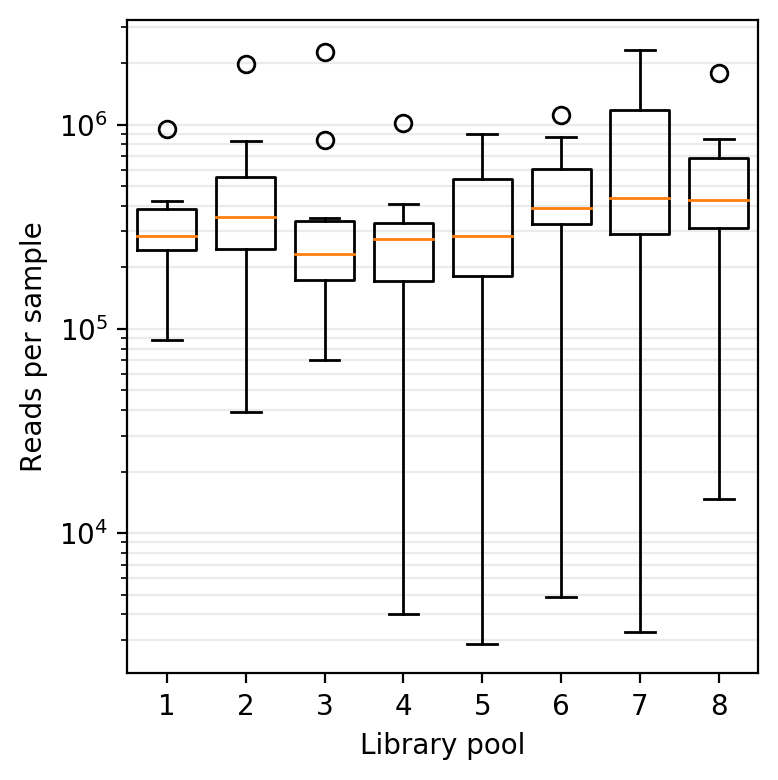

In [46]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["NumReads"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.grid(axis='y', which='both', alpha=0.25)
ax.set_xlabel("Library pool")
ax.set_ylabel("Reads per sample")
plt.tight_layout()

### Reads mapped

In [47]:
print("Normality test")
normal_test(numeric_stats["ReadsMapped"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["ReadsMapped"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["ReadsMapped"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["ReadsMapped"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==2]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==3]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==4]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==5]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==6]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==7]["ReadsMapped"],
                         log_numeric.loc[log_numeric["pool"]==8]["ReadsMapped"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="ReadsMapped", between="pool", data=log_numeric))

print("\nLog-transformed Krusckal-Wallis test")
pg.print_table(pg.kruskal(data=log_numeric, dv="ReadsMapped", between="pool"))

Normality test
p = 8.57436e-33
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=192.83143064233758, pvalue=3.778063994629479e-38)

Log-transformed normality test
p = 0.0028637
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=22.486274620605506, pvalue=0.0020934467903370403)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7   36.816  8.211    0.000  0.252


Log-transformed Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  33.419    0.000



- Log-transforming makes data better fit assumptions, but still not normal
- Log-transformed variances are not equal at _p_<0.01
- Group tests are highly significant 

**Therefore, the number of mapped reads per individual is significantly different between pools.** I expect this pattern to extend to the percent of reads on target.

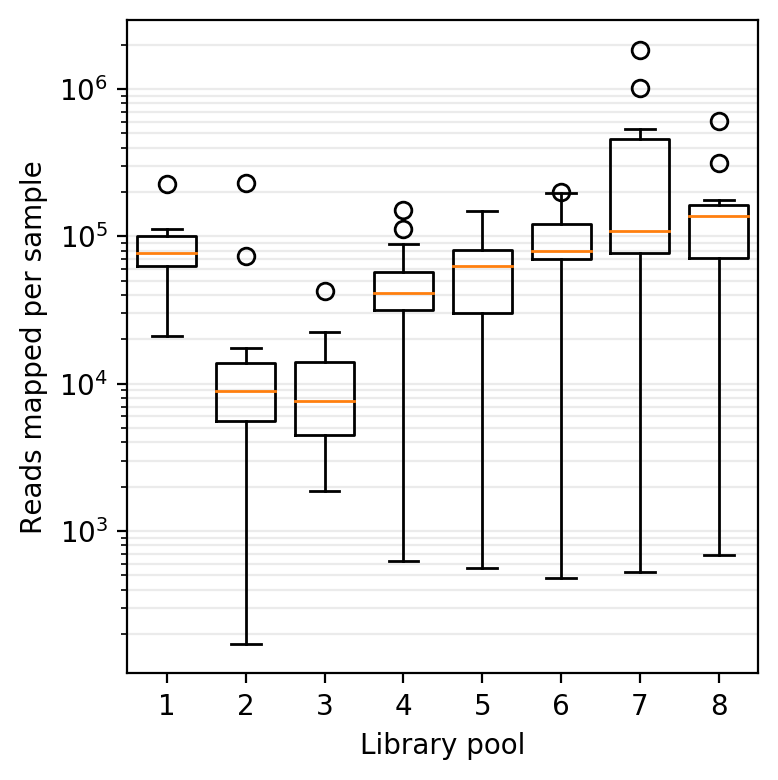

In [48]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["ReadsMapped"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.grid(axis='y', which='both', alpha=0.25)
ax.set_xlabel("Library pool")
ax.set_ylabel("Reads mapped per sample")
plt.tight_layout()

### Fraction of reads on target

In [49]:
print("Normality test")
normal_test(numeric_stats["PctOnTarget"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["PctOnTarget"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["PctOnTarget"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["PctOnTarget"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==2]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==3]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==4]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==5]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==6]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==7]["PctOnTarget"],
                         log_numeric.loc[log_numeric["pool"]==8]["PctOnTarget"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="PctOnTarget", between="pool", data=log_numeric))

print("\nLog-transformed Krusckal-Wallis test")
pg.print_table(pg.kruskal(data=log_numeric, dv="PctOnTarget", between="pool"))

Normality test
p = 5.54648e-08
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=86.83575306924652, pvalue=5.515560749085978e-16)

Log-transformed normality test
p = 0.000795709
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=54.80953300460032, pvalue=1.6262326017238918e-09)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2       F    p-unc    np2
--------  -------  -------  ------  -------  -----
pool            7   34.544  50.564    0.000  0.758


Log-transformed Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  59.764    0.000



- Mapping efficiency is **non-normally** distributed, whether raw or transformed
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
- **Welch's ANOVA** and **KW test** using **log-transformed** are both **highly significant**

**Therefore, the fraction of reads on target per individual is significantly different between pools.**

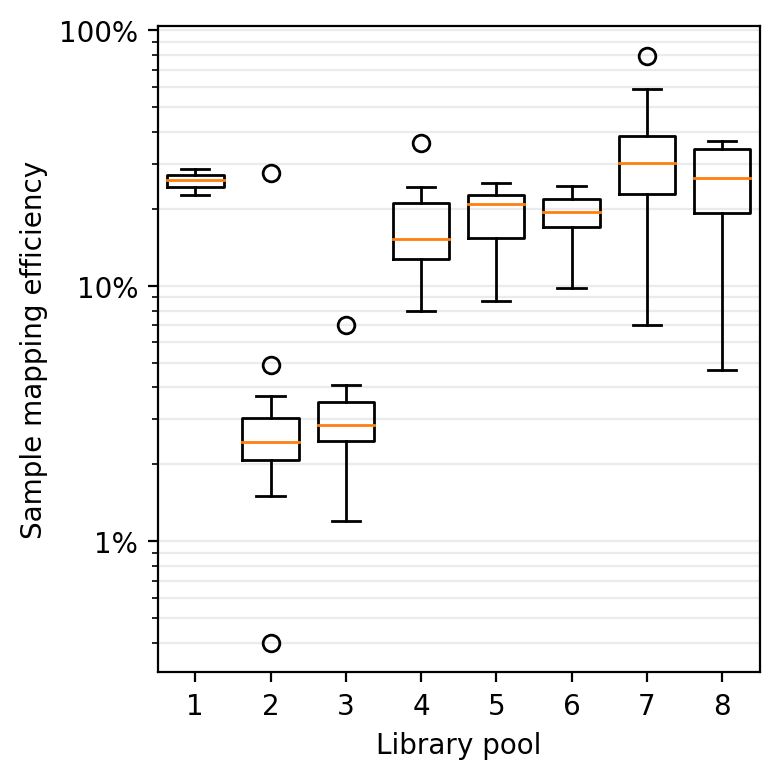

In [50]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["PctOnTarget"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("Sample mapping efficiency")
ax.set_yticks([0.01, 0.1, 1.0])
ax.set_yticklabels(["1%", "10%", "100%"])
ax.grid(axis='y', which='both', alpha=0.25)
plt.tight_layout()

### Genes with exon sequences

In [51]:
print("Normality test")
normal_test(numeric_stats["GenesWithSeqs"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["GenesWithSeqs"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["GenesWithSeqs"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["GenesWithSeqs"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==2]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==3]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==4]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==5]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==6]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==7]["GenesWithSeqs"],
                         log_numeric.loc[log_numeric["pool"]==8]["GenesWithSeqs"])
print(barlett)

print("\nLog-transformed Welch's ANOVA")
pg.print_table(pg.welch_anova(dv="GenesWithSeqs", between="pool", data=log_numeric))

print("\nKrusckal-Wallis test")
pg.print_table(pg.kruskal(data=numeric_stats, dv="GenesWithSeqs", between="pool"))

Normality test
p = 6.16448e-47
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=30.44516618064905, pvalue=7.866549685976865e-05)

Log-transformed normality test
p = 3.42429e-05
The null hypothesis can be rejected. Data are not-normal.

Log-transformed Barlett's test
BartlettResult(statistic=50.81325099631971, pvalue=9.998374806071448e-09)

Log-transformed Welch's ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2       F    p-unc    np2
--------  -------  -------  ------  -------  -----
pool            7   33.582  15.036    0.000  0.281


Krusckal-Wallis test
Source      ddof1       H    p-unc
--------  -------  ------  -------
pool            7  38.327    0.000



- The number of genes with exon sequence is **non-normally** distributed, whether raw or transformed
    - It is closer to normal when raw
- The pools have **unequal variances** and variance is smaller when data are **log-transformed**
    - Pools are more homoscedastic when log transformed
    - Log-transforming doesn't make as much sense here though because we are more interested in linear rather than multiplicative differences
- **Welch's ANOVA** using **log-transformed** data and **KW test** using **raw** data are both **highly significant**

**Therefore, the number of genes with contigs per individual is significantly different between pools.**

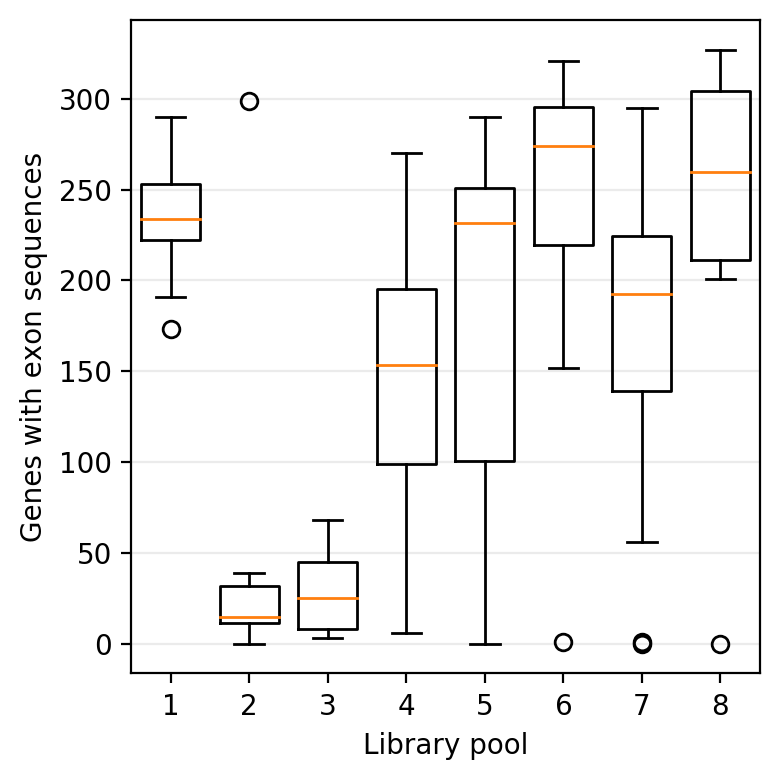

In [52]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["GenesWithSeqs"], widths=[0.75],
               bootstrap=100, positions=[i])

ax.set_xlabel("Library pool")
ax.set_ylabel("Genes with exon sequences")
ax.grid(axis='y', which='both', alpha=0.25)

plt.tight_layout()

We found the `ReadsMapped`, `PctOnTarget`, and `GenesWithContigs` varied between pools. Data were non-normal with unequal variances in all cases so we will use Dunn's test t test for population level differences among pools.

In [53]:
dunn_readsmapped = skph.posthoc_dunn(log_numeric, val_col='ReadsMapped', group_col="pool", p_adjust=None, sort=True)
dunn_ontarget = skph.posthoc_dunn(log_numeric, val_col='PctOnTarget', group_col="pool", p_adjust=None, sort=True)
dunn_gwc = skph.posthoc_dunn(numeric_stats, val_col='GenesWithSeqs', group_col="pool", p_adjust=None, sort=True)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


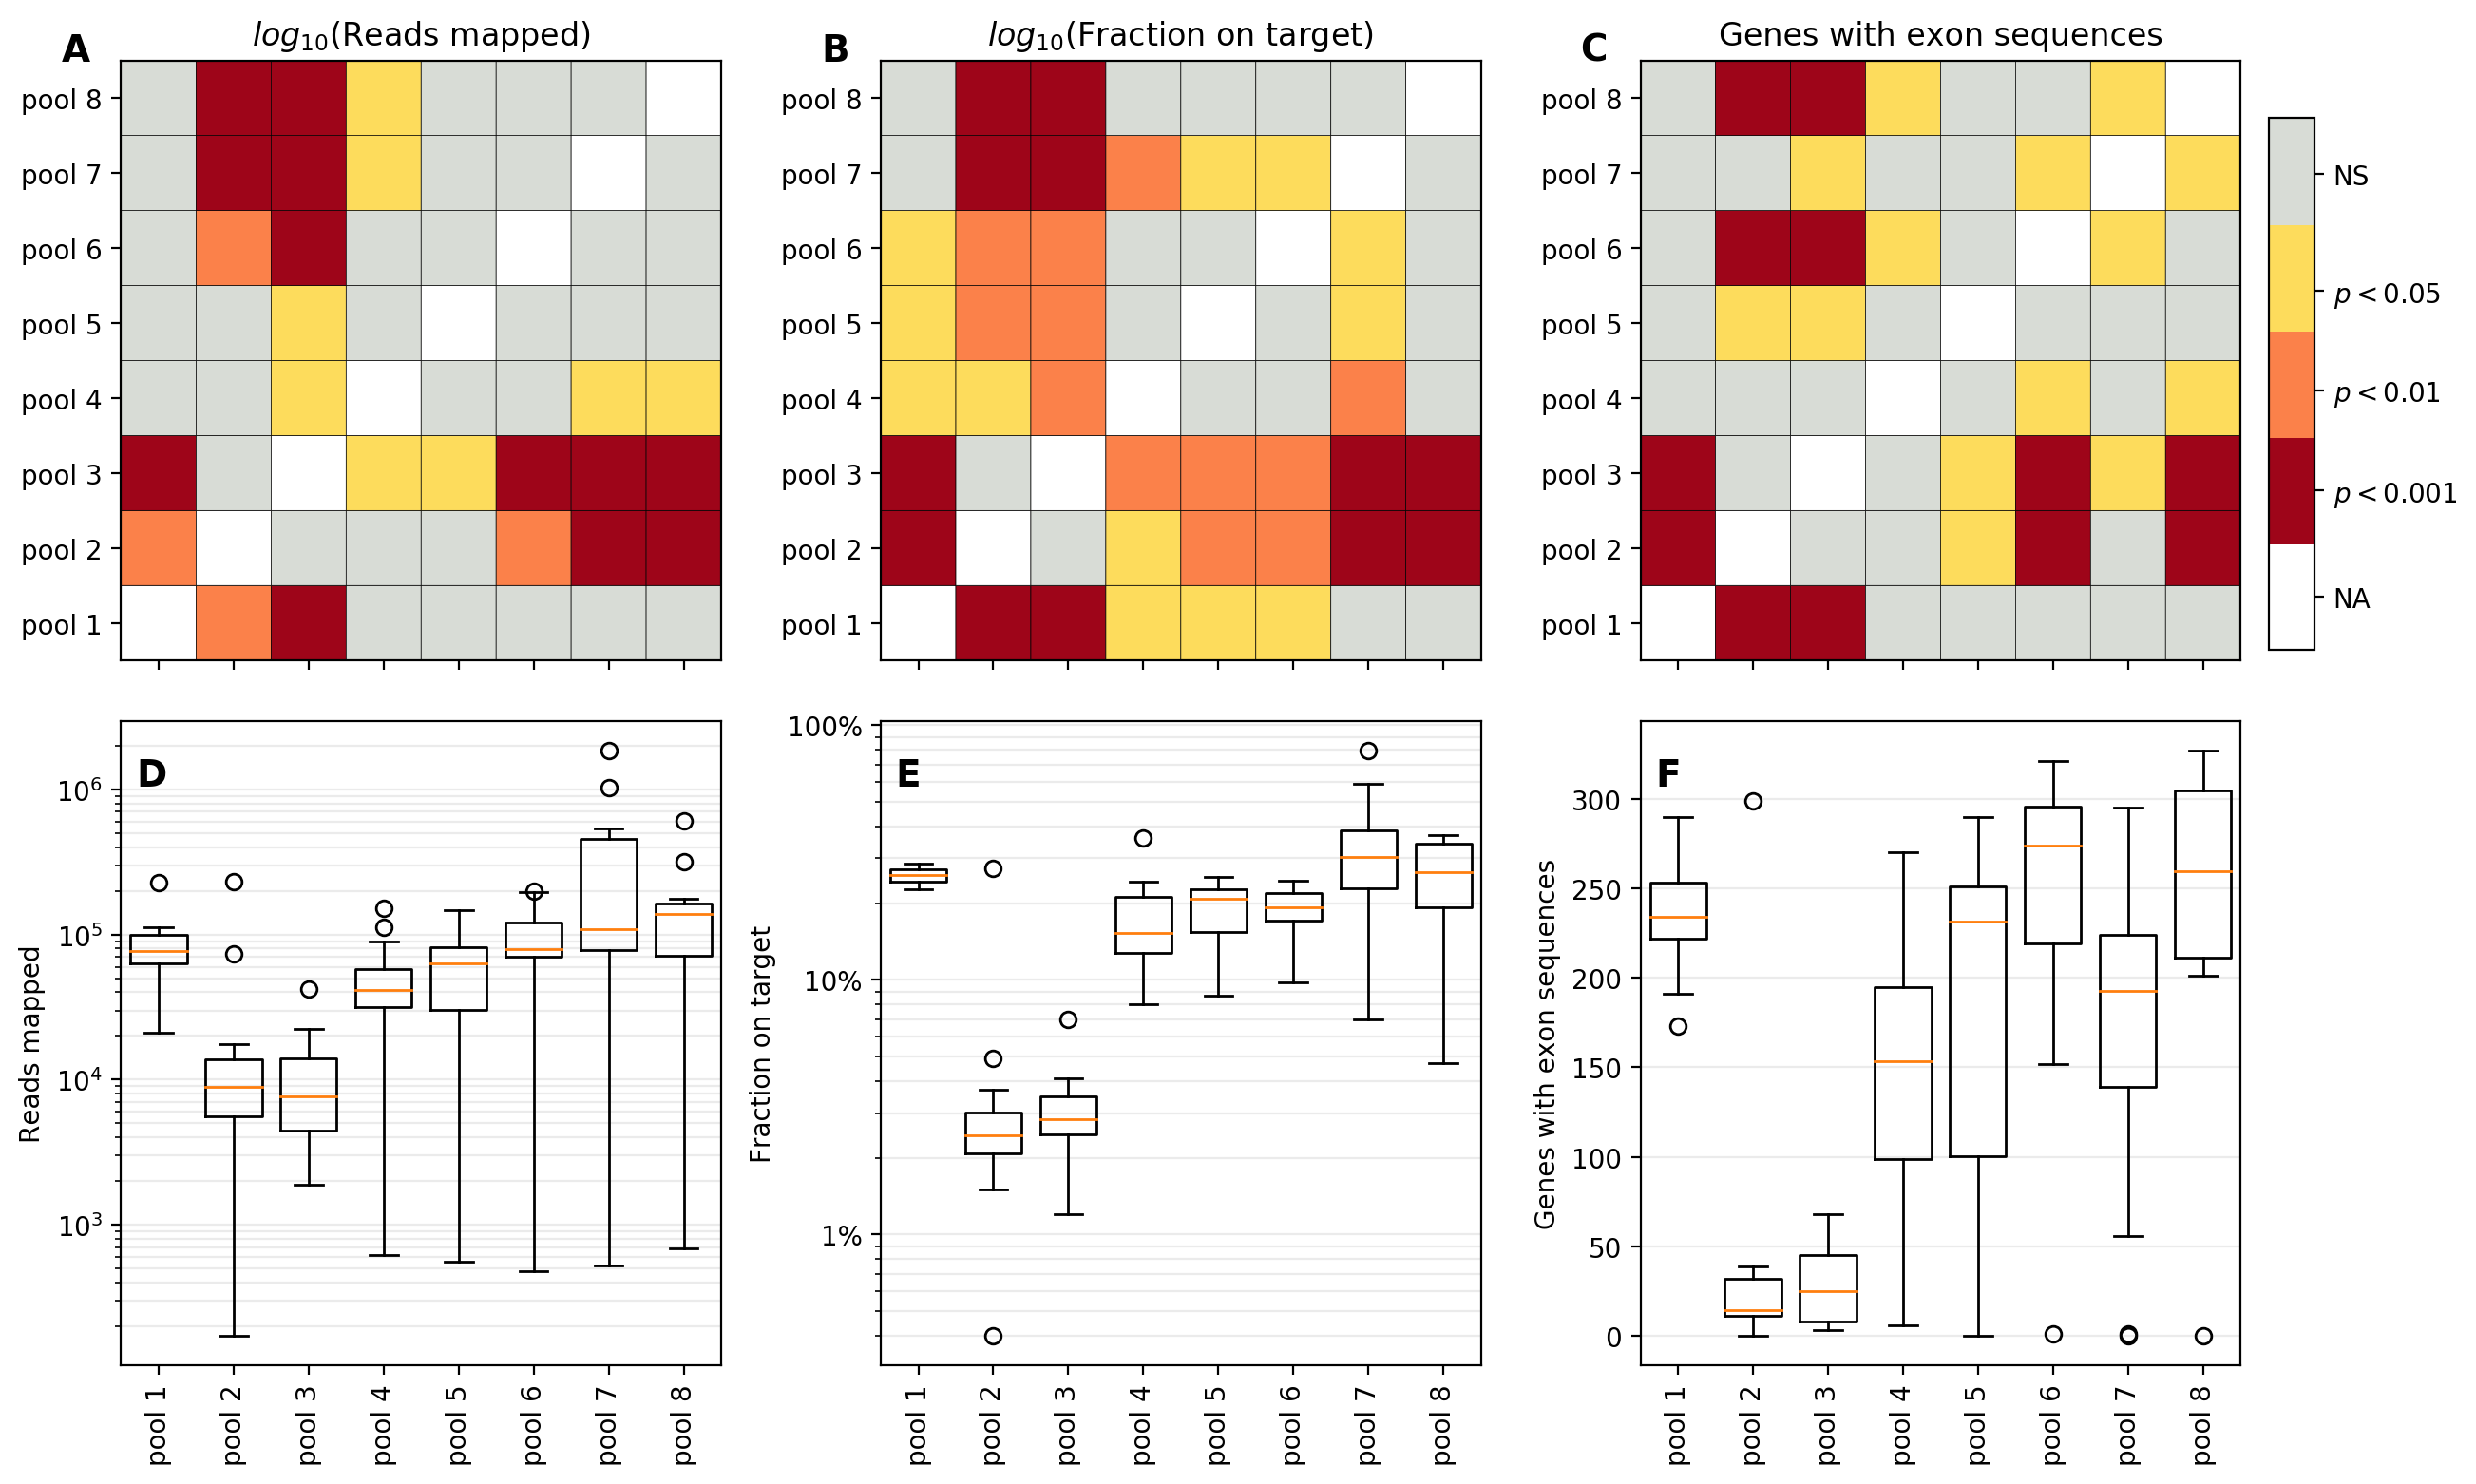

In [54]:
plt.style.use('default')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=True)

cmaplist = ["white", "xkcd:carmine", "xkcd:orangish", "xkcd:light gold", "xkcd:light grey"]
cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = [-1, 0.0, 0.001, 0.01, 0.05, 1.0]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pmap_rm = ax[0,0].pcolor(dunn_readsmapped, cmap=cmap, norm=norm, edgecolors="black")
pmap_ot = ax[0,1].pcolor(dunn_ontarget, cmap=cmap, norm=norm, edgecolors="black")
pmap_gwc = ax[0,2].pcolor(dunn_gwc, cmap=cmap, norm=norm, edgecolors="black")

cax = fig.add_axes([ax[0,-1].get_position().x1+0.1, ax[0,-1].get_position().y0+0.025, 
                    0.02, ax[0,-1].get_position().height])
cbar = plt.colorbar(pmap_gwc, cax=cax, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-0.5, 0.0005, 0.005, 0.025, 0.5])
cbar.ax.set_yticklabels(["NA", "$p<0.001$", "$p<0.01$", "$p<0.05$", "NS"])

for i in range(1,9):
    ax[1,0].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["ReadsMapped"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])
    ax[1,1].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["PctOnTarget"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])
    ax[1,2].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["GenesWithSeqs"], widths=[0.75],
               bootstrap=1000, positions=[i-0.5])

ax[0,0].set_title("$log_{10}($Reads mapped$)$")
ax[0,1].set_title("$log_{10}($Fraction on target$)$")
ax[0,2].set_title("Genes with exon sequences")

for i in range(3):
    ax[0,i].set_aspect('equal','box')

    ax[0,i].set_yticks(np.linspace(0.5, 7.5, 8))
    ax[0,i].set_yticklabels(["pool {}".format(i) for i in range(1,9)])
    
    ax[1,i].grid(axis="y", which="both", alpha=0.25)
    ax[1,i].set_xticks(np.linspace(0.5, 7.5, 8))
    ax[1,i].set_xticklabels(["pool {}".format(i) for i in range(1,9)], rotation=90)

for i, axis in enumerate(ax.flatten()):
    if i<3:
        axis.annotate(string.ascii_uppercase[i], xy=(-0.1, 1.), xycoords="axes fraction", 
                        weight='bold', size=14)
    else:
        axis.annotate(string.ascii_uppercase[i], xy=(0.025, 0.90), xycoords="axes fraction", 
                        weight='bold', size=14)

ax[1,0].semilogy()
ax[1,1].semilogy()
ax[1,1].set_yticks([0.01, 0.1, 1.0])
ax[1,1].set_yticklabels(["1%", "10%", "100%"])

ax[1,0].set_ylabel("Reads mapped")
ax[1,1].set_ylabel("Fraction on target")
ax[1,2].set_ylabel("Genes with exon sequences")

plt.tight_layout()
# plt.savefig("../Figures/Statistics/Appendix_S6.pdf", format='pdf', dpi=300, transparent=True, bbox_inches="tight")

## Effects of sample quality
We were able to detect batch effects (i.e. there was variance between sample pools), and now I'll see if there are individual effects (i.e. artifacts of sample quality). Namely, I'll be looking at in initial sample concentration and DNA mass. Low concentration samples are likely lower quality extractions, and the library preparation recommended a minimum of 100ng DNA. 

### Initial sample concentration
Are these differences in the sample quality of different pools that might have caused the differential success?

In [55]:
print("Normality test")
normal_test(numeric_stats["initial_concentration"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["initial_concentration"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["initial_concentration"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_concentration"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==2]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==3]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==4]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==5]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==6]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==7]["initial_concentration"],
                         log_numeric.loc[log_numeric["pool"]==8]["initial_concentration"])
print(barlett)

print("\nLog-transformed one-way ANOVA")
pg.print_table(pg.anova(dv="initial_concentration", between="pool", data=log_numeric))

Normality test
p = 1.1734e-25
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=111.83472705722245, pvalue=3.821079293201155e-21)

Log-transformed normality test
p = 0.140895
The null hypothesis cannot be rejected. Data are normal.

Log-transformed Barlett's test
BartlettResult(statistic=9.318020931532134, pvalue=0.23062263124918805)

Log-transformed one-way ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7       88  2.976    0.008  0.191



The **log-transformed data are normal with relatively equal variances**, so I applied a standard **one-way ANOVA** on the log-transformed data. This showed that there are indeed **differences in group means**.

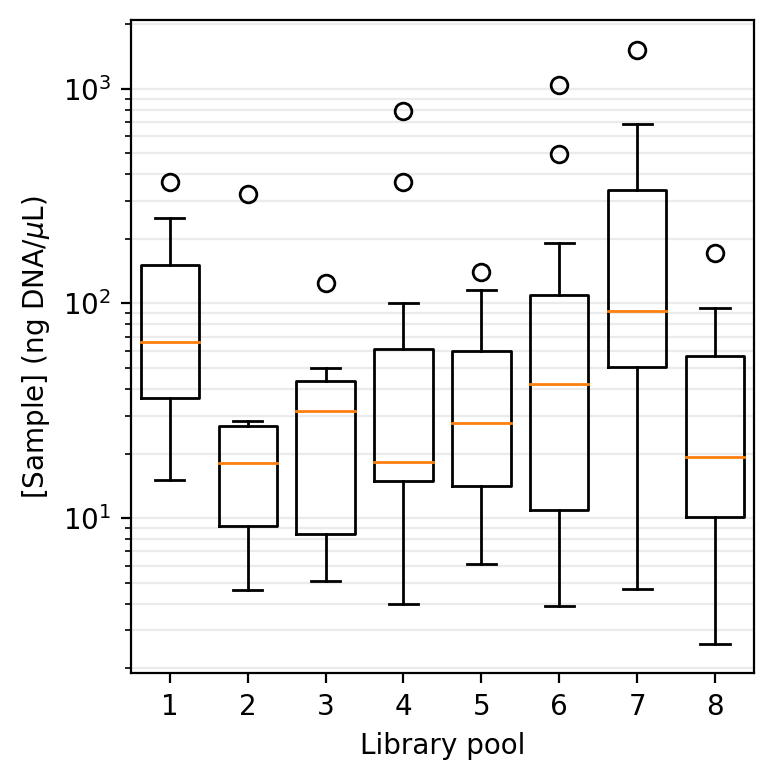

In [56]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_concentration"], widths=[0.75],
               bootstrap=100, positions=[i])
ax.semilogy()
ax.set_xlabel("Library pool")
ax.set_ylabel("[Sample] (ng DNA/$\mu$L)")
ax.grid(axis='y', which='both', alpha=0.25)

plt.tight_layout()

In [57]:
print("Normality test")
normal_test(numeric_stats["initial_ng_DNA"], alpha=0.01, log=False)

print("\nBarlett's test")
barlett = stats.bartlett(numeric_stats.loc[numeric_stats["pool"]==1]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==2]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==3]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==4]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==5]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==6]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==7]["initial_ng_DNA"],
                         numeric_stats.loc[numeric_stats["pool"]==8]["initial_ng_DNA"])
print(barlett)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_ng_DNA"], alpha=0.01, log=False)

print("\nLog-transformed Barlett's test")
barlett = stats.bartlett(log_numeric.loc[log_numeric["pool"]==1]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==2]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==3]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==4]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==5]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==6]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==7]["initial_ng_DNA"],
                         log_numeric.loc[log_numeric["pool"]==8]["initial_ng_DNA"])
print(barlett)

print("\nLog-transformed one-way ANOVA")
pg.print_table(pg.anova(dv="initial_ng_DNA", between="pool", data=log_numeric))

Normality test
p = 1.19722e-24
The null hypothesis can be rejected. Data are not-normal.

Barlett's test
BartlettResult(statistic=226.92822669808749, pvalue=2.23008372289206e-45)

Log-transformed normality test
p = 0.166484
The null hypothesis cannot be rejected. Data are normal.

Log-transformed Barlett's test
BartlettResult(statistic=14.431658708033844, pvalue=0.04401539741014799)

Log-transformed one-way ANOVA

ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2
--------  -------  -------  -----  -------  -----
pool            7       88  4.532    0.000  0.265



The **log-transformed data are normal with relatively equal variances** ($p>0.01$), so I applied a standard **one-way ANOVA** on the log-transformed data. This showed that there are indeed **differences in group means**.

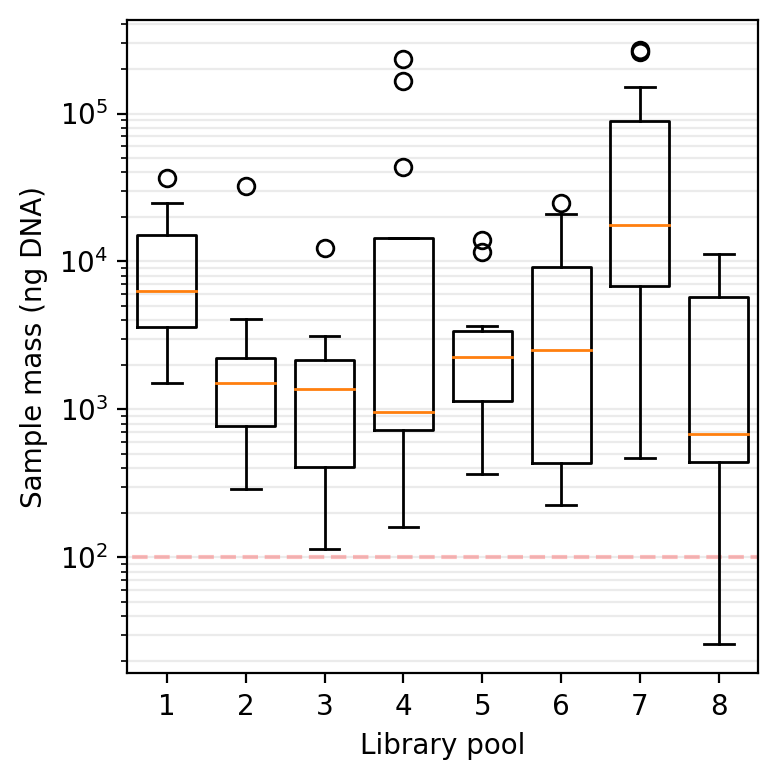

In [58]:
fig, ax = plt.subplots(figsize=(4,4))

for i in range(1,9):
    ax.boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_ng_DNA"], widths=[0.75],
               bootstrap=100, positions=[i])
ax.semilogy()
ax.hlines(y=100, xmin=0, xmax=10, color="red", alpha=0.25, linestyle="--")
ax.set_xlabel("Library pool")
ax.set_ylabel("Sample mass (ng DNA)")
ax.grid(axis='y', which='both', alpha=0.25)
ax.set_xlim(0.5, 8.5)

plt.tight_layout()

Since we used standard ANOVAs, we can apply post-hoc Tukey HSD to identify group differences.

In [59]:
tukey_conc = skph.posthoc_tukey(a=log_numeric, val_col="initial_concentration", group_col="pool", sort=True)
tukey_mass = skph.posthoc_tukey(a=log_numeric, val_col="initial_ng_DNA", group_col="pool", sort=True)

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


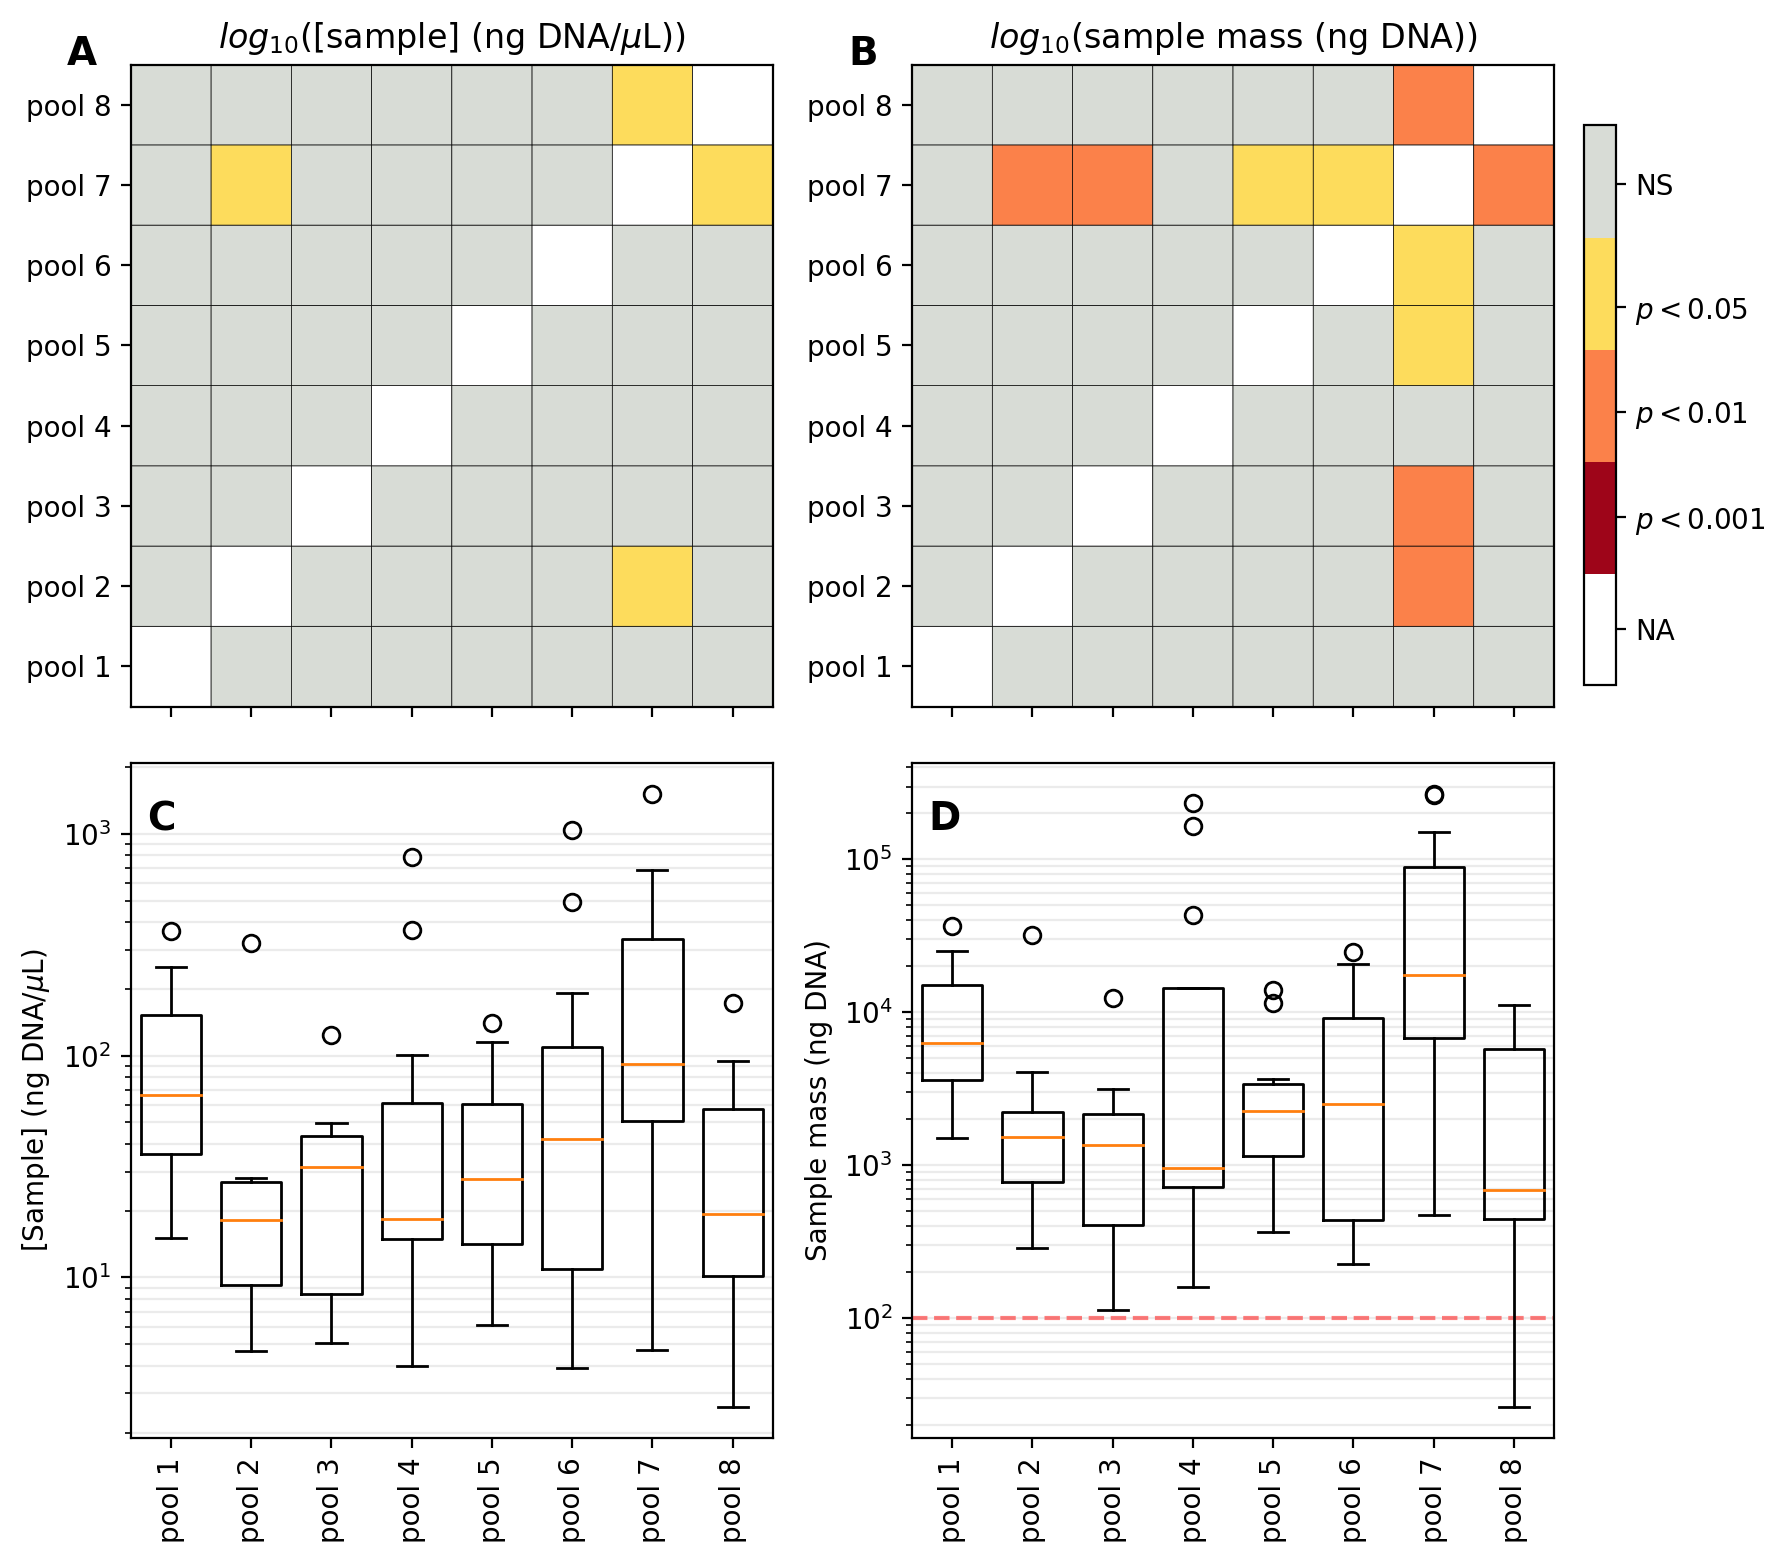

In [60]:
plt.style.use('default')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True)

cmaplist = ["white", "xkcd:carmine", "xkcd:orangish", "xkcd:light gold", "xkcd:light grey"]
cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = [-1, 0.0, 0.001, 0.01, 0.05, 1.0]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

pmap_conc = ax[0,0].pcolor(tukey_conc, cmap=cmap, norm=norm, edgecolors="black")
pmap_mass = ax[0,1].pcolor(tukey_mass, cmap=cmap, norm=norm, edgecolors="black")

cax = fig.add_axes([ax[0,-1].get_position().x1+0.1, ax[0,-1].get_position().y0+0.025, 
                    0.02, ax[0,-1].get_position().height])
cbar = plt.colorbar(pmap_mass, cax=cax, cmap=cmap, norm=norm, boundaries=bounds, 
                    ticks=[-0.5, 0.0005, 0.005, 0.025, 0.5])
cbar.ax.set_yticklabels(["NA", "$p<0.001$", "$p<0.01$", "$p<0.05$", "NS"])

for i in range(1,9):
    ax[1,0].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_concentration"], widths=[0.75],
               bootstrap=100, positions=[i-0.5])
    ax[1,1].boxplot(numeric_stats.loc[numeric_stats["pool"]==i]["initial_ng_DNA"], widths=[0.75],
               bootstrap=100, positions=[i-0.5])
ax[1,1].hlines(y=100, xmin=0, xmax=10, color="red", alpha=0.5, linestyle="--")

ax[0,0].set_title("$log_{10}$([sample] (ng DNA/$\mu$L))")
ax[0,1].set_title("$log_{10}$(sample mass (ng DNA))")

for i in range(2):
    ax[0,i].set_aspect('equal','box')

    ax[0,i].set_yticks(np.linspace(0.5, 7.5, 8))
    ax[0,i].set_yticklabels(["pool {}".format(i) for i in range(1,9)])
    
    ax[1,i].grid(axis="y", which="both", alpha=0.25)
    ax[1,i].set_xticks(np.linspace(0.5, 7.5, 8))
    ax[1,i].set_xticklabels(["pool {}".format(i) for i in range(1,9)], rotation=90)
    ax[1,i].set_xlim(0, 8)

for i, axis in enumerate(ax.flatten()):
    if i<2:
        axis.annotate(string.ascii_uppercase[i], xy=(-0.1, 1.), xycoords="axes fraction", 
                        weight='bold', size=14)
    else:
        axis.annotate(string.ascii_uppercase[i], xy=(0.025, 0.90), xycoords="axes fraction", 
                        weight='bold', size=14)
ax[1,0].semilogy()
ax[1,1].semilogy()

ax[1,0].set_ylabel("[Sample] (ng DNA/$\mu$L)")
ax[1,1].set_ylabel("Sample mass (ng DNA)")

plt.tight_layout()
# plt.savefig("../Figures/Statistics/Appendix_S7.pdf", format='pdf', dpi=300, transparent=True, bbox_inches="tight")

So there are only a few pools that differ in sample quality. It seems unlikely, but perhaps the differences in sample mass are related the differential success of some of the library pools. If this is the case, we expect there to be a relationship between sample quality and read statistics that lead to overall lower or highr performance of particular libraries. To do this, I'll run a few regressions.

In [61]:
X = log_numeric["initial_concentration"]
y = log_numeric["ReadsMapped"]
X = sm.add_constant(X)

mod_ic = sm.OLS(y, X).fit()
mod_ic = mod_ic.get_robustcov_results()
print(mod_ic.summary())

                            OLS Regression Results                            
Dep. Variable:            ReadsMapped   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.875
Date:                Sun, 21 Mar 2021   Prob (F-statistic):             0.0520
Time:                        19:24:33   Log-Likelihood:                -110.50
No. Observations:                  96   AIC:                             225.0
Df Residuals:                      94   BIC:                             230.1
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.20

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


So it doesn't look like the number of reads mapped is related to the initial concentration because the slope is not significantly different from 0.

### Initial sample mass

In [62]:
print("Normality test")
normal_test(numeric_stats["initial_ng_DNA"], alpha=0.01, log=False)

print("\nLog-transformed normality test")
normal_test(log_numeric["initial_ng_DNA"], alpha=0.01, log=False)

Normality test
p = 1.19722e-24
The null hypothesis can be rejected. Data are not-normal.

Log-transformed normality test
p = 0.166484
The null hypothesis cannot be rejected. Data are normal.


(3.5857142578455, 0.16648382375222465)

Again, we'll go ahead with the log-transformed data.

In [63]:
X = log_numeric["initial_ng_DNA"]
X = sm.add_constant(X)

y_nr = log_numeric["NumReads"]
y_rm = log_numeric["ReadsMapped"]
y_ot = log_numeric["PctOnTarget"]
y_gwc = log_numeric["GenesWithSeqs"]

nr_mass = sm.OLS(y_nr, X).fit().get_robustcov_results()
rm_mass = sm.OLS(y_rm, X).fit().get_robustcov_results()
ot_mass = sm.OLS(y_ot, X).fit().get_robustcov_results()
gwc_mass = sm.OLS(y_gwc, X).fit().get_robustcov_results()

In [64]:
print(nr_mass.summary2())
print(rm_mass.summary2())
print(ot_mass.summary2())
print(gwc_mass.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.011  
Dependent Variable: NumReads         AIC:                168.6545
Date:               2021-03-21 19:24 BIC:                173.7832
No. Observations:   96               Log-Likelihood:     -82.327 
Df Model:           1                F-statistic:        0.008847
Df Residuals:       94               Prob (F-statistic): 0.925   
R-squared:          0.000            Scale:              0.33231 
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
const           5.4189    0.2499  21.6804  0.0000   4.9226  5.9151
initial_ng_DNA  0.0068    0.0727   0.0941  0.9253  -0.1376  0.1512
-----------------------------------------------------------------
Omnibus:             46.663       Durbin-Watson:          1.812  
Prob(Omnibus):       0

### Initial sample concentration

In [65]:
X = log_numeric["initial_concentration"]
X = sm.add_constant(X)

y_nr = log_numeric["NumReads"]
y_rm = log_numeric["ReadsMapped"]
y_ot = log_numeric["PctOnTarget"]
y_gwc = log_numeric["GenesWithSeqs"]

nr_conc = sm.OLS(y_nr, X).fit().get_robustcov_results()
rm_conc = sm.OLS(y_rm, X).fit().get_robustcov_results()
ot_conc = sm.OLS(y_ot, X).fit().get_robustcov_results()
gwc_conc = sm.OLS(y_gwc, X).fit().get_robustcov_results()

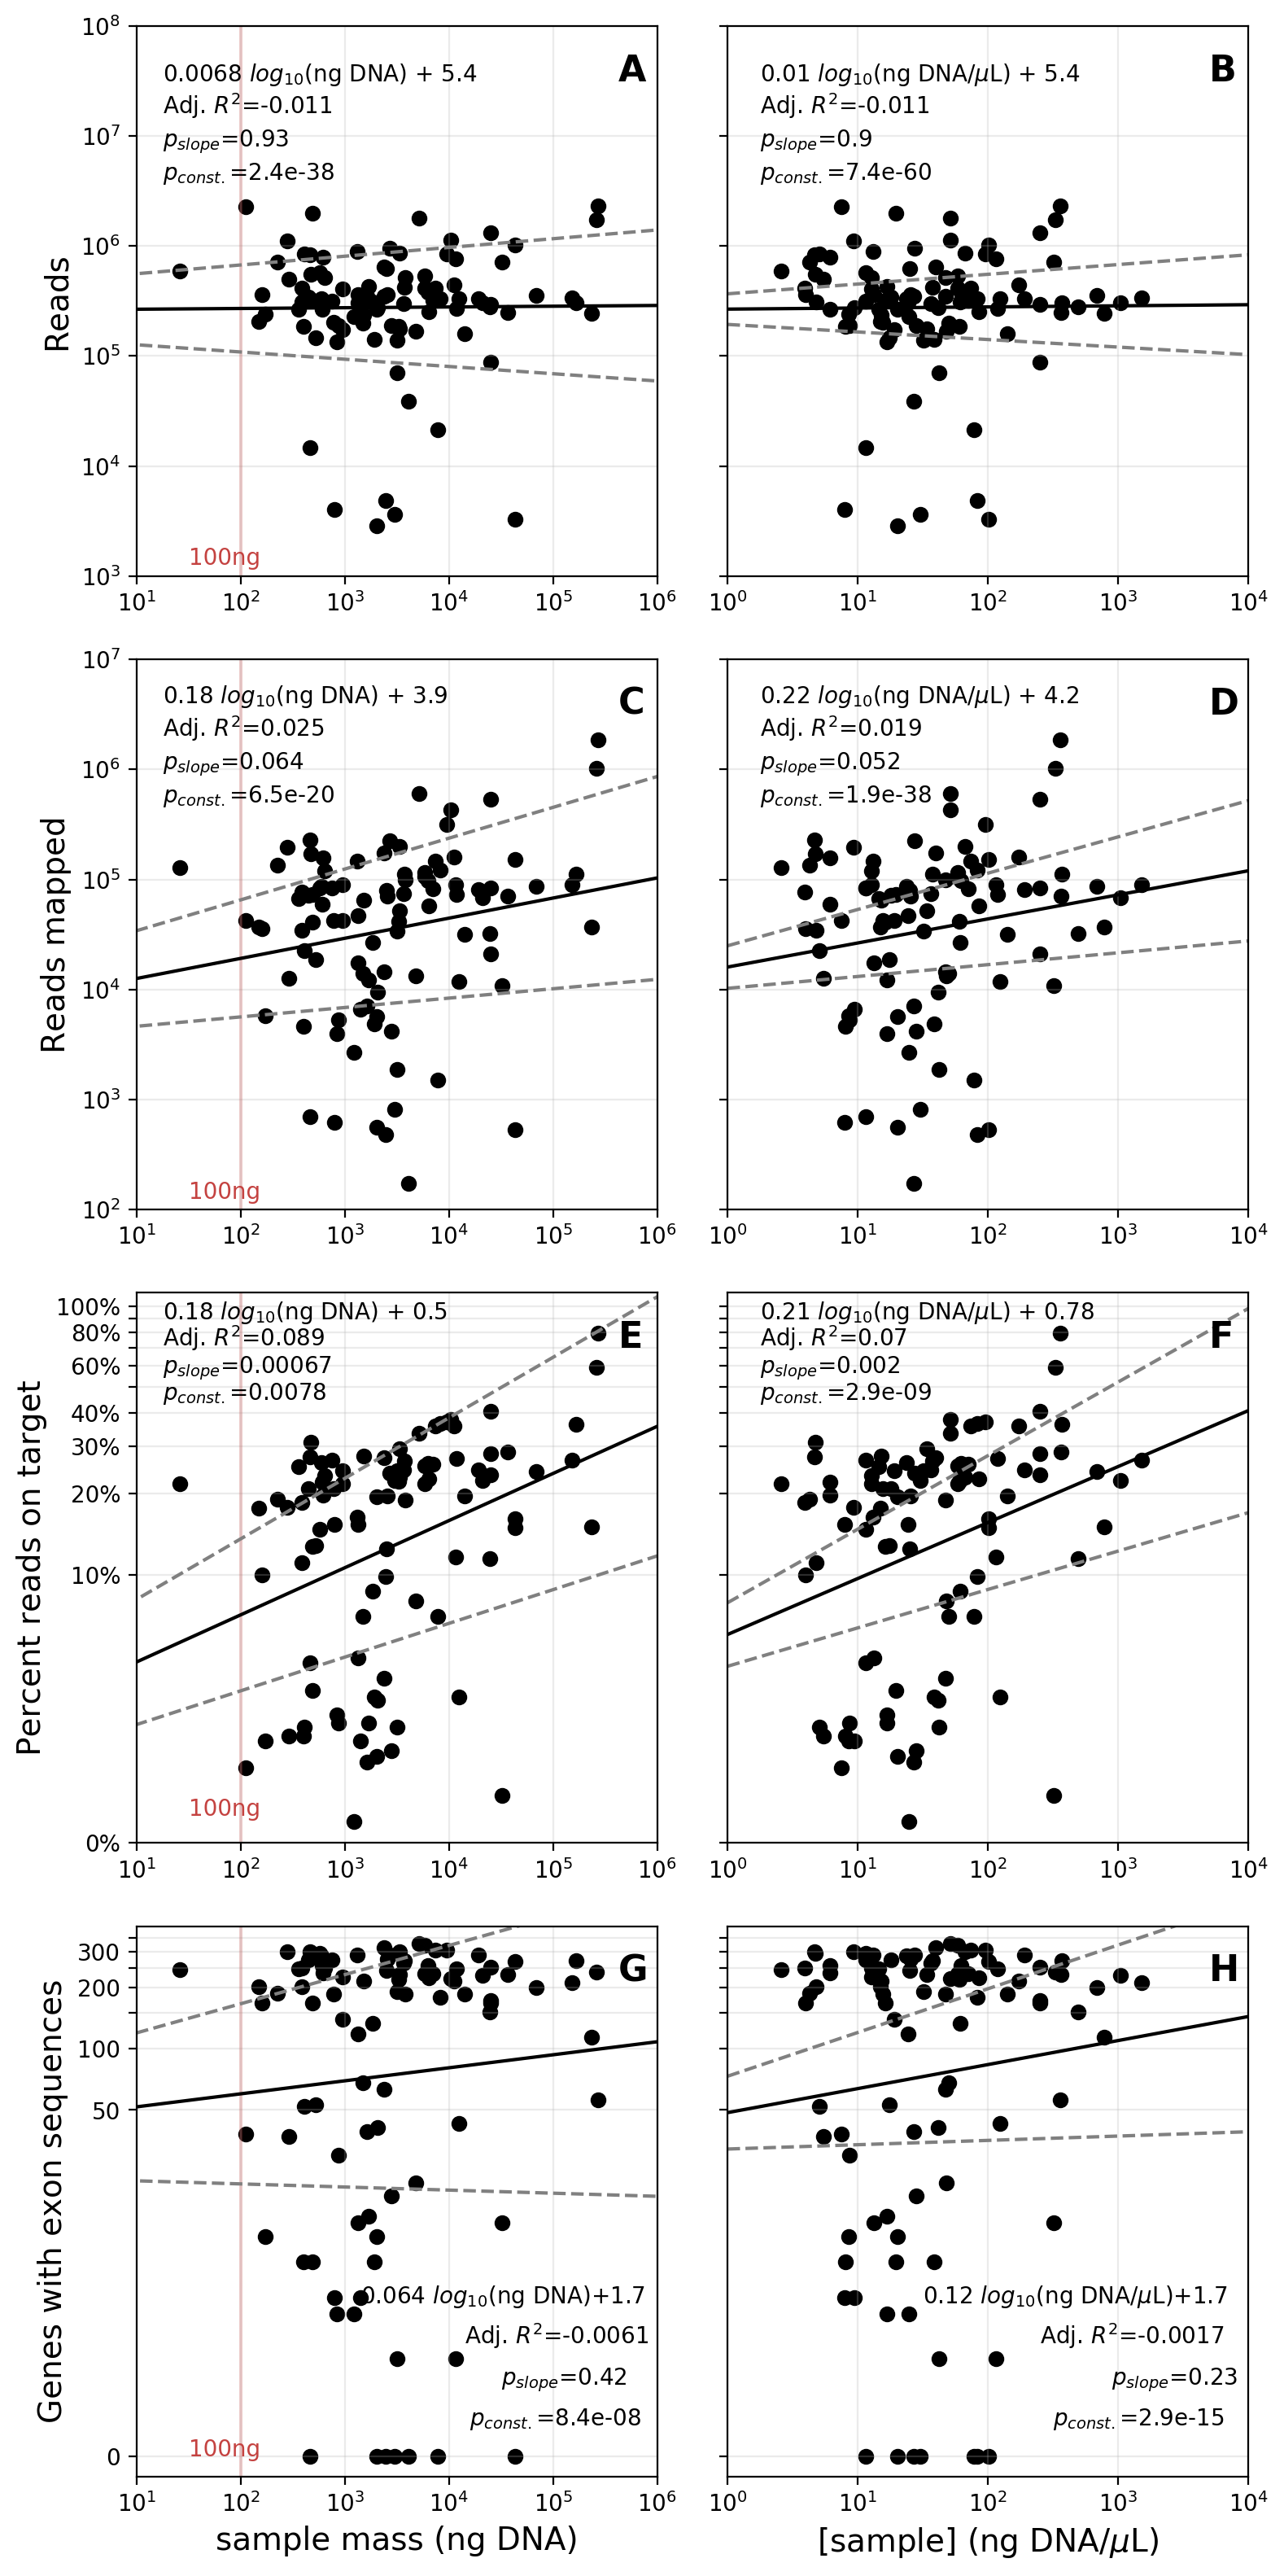

In [66]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8,16), sharey='row')


intercept, slope = nr_mass.params
intercept_stderr, slope_stderr = nr_mass.bse
intercept_p, slope_p = nr_mass.pvalues
adjRsq = nr_mass.rsquared_adj
domain=np.linspace(0, 10, 1000)
ax[0,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["NumReads"], color="black")
ax[0,0].plot(domain, intercept + (slope*domain), color="black")
ax[0,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[0,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[0,0].text(x=1.25, y=7.5, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[0,0].text(x=1.25, y=7.2, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[0,0].text(x=1.25, y=6.9, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[0,0].text(x=1.25, y=6.6, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = rm_mass.params
intercept_stderr, slope_stderr = rm_mass.bse
intercept_p, slope_p = rm_mass.pvalues
adjRsq = rm_mass.rsquared_adj
ax[1,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["ReadsMapped"], color="black")
ax[1,0].plot(domain, intercept + (slope*domain), color="black")
ax[1,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[1,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[1,0].text(x=1.25, y=6.6, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[1,0].text(x=1.25, y=6.3, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[1,0].text(x=1.25, y=6.0, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[1,0].text(x=1.25, y=5.7, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = ot_mass.params
intercept_stderr, slope_stderr = ot_mass.bse
intercept_p, slope_p = ot_mass.pvalues
adjRsq = ot_mass.rsquared_adj
ax[2,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["PctOnTarget"], color="black")
ax[2,0].plot(domain, intercept + (slope*domain), color="black")
ax[2,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[2,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[2,0].text(x=1.25, y=1.95, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[2,0].text(x=1.25, y=1.85, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[2,0].text(x=1.25, y=1.75, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[2,0].text(x=1.25, y=1.65, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = gwc_mass.params
intercept_stderr, slope_stderr = gwc_mass.bse
intercept_p, slope_p = gwc_mass.pvalues
adjRsq = gwc_mass.rsquared_adj
ax[3,0].scatter(x=log_numeric["initial_ng_DNA"], y=log_numeric["GenesWithSeqs"], color="black")
ax[3,0].plot(domain, intercept + (slope*domain), color="black")
ax[3,0].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[3,0].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")
# ax[3,0].hlines(y=np.log10(353), xmin=0, xmax=6, color="green", alpha=0.5, linestyle="-")

ax[3,0].text(x=3.15, y=0.75, s="{:1.2} {}+{:1.2}".format(slope, "$log_{10}$(ng DNA)", intercept))
ax[3,0].text(x=4.15, y=0.55, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[3,0].text(x=4.5, y=0.35, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[3,0].text(x=4.2, y=0.15, s="{}={:1.2}".format("$p_{const.}$", intercept_p))
# ax[3,0].text(x=5.5, y=np.log10(400), s="353", color="green")

intercept, slope = nr_conc.params
intercept_stderr, slope_stderr = nr_conc.bse
intercept_p, slope_p = nr_conc.pvalues
adjRsq = nr_conc.rsquared_adj
domain=np.linspace(0, 10, 1000)
ax[0,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["NumReads"], color="black")
ax[0,1].plot(domain, intercept + (slope*domain), color="black")
ax[0,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[0,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[0,1].text(x=0.25, y=7.5, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[0,1].text(x=0.25, y=7.2, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[0,1].text(x=0.25, y=6.9, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[0,1].text(x=0.25, y=6.6, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = rm_conc.params
intercept_stderr, slope_stderr = rm_conc.bse
intercept_p, slope_p = rm_conc.pvalues
adjRsq = rm_conc.rsquared_adj
ax[1,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["ReadsMapped"], color="black")
ax[1,1].plot(domain, intercept + (slope*domain), color="black")
ax[1,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[1,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[1,1].text(x=0.25, y=6.6, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[1,1].text(x=0.25, y=6.3, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[1,1].text(x=0.25, y=6.0, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[1,1].text(x=0.25, y=5.7, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = ot_conc.params
intercept_stderr, slope_stderr = ot_conc.bse
intercept_p, slope_p = ot_conc.pvalues
adjRsq = ot_conc.rsquared_adj
ax[2,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["PctOnTarget"], color="black")
ax[2,1].plot(domain, intercept + (slope*domain), color="black")
ax[2,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[2,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")

ax[2,1].text(x=0.25, y=1.95, s="{:1.2} {} + {:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[2,1].text(x=0.25, y=1.85, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[2,1].text(x=0.25, y=1.75, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[2,1].text(x=0.25, y=1.65, s="{}={:1.2}".format("$p_{const.}$", intercept_p))

intercept, slope = gwc_conc.params
intercept_stderr, slope_stderr = gwc_conc.bse
intercept_p, slope_p = gwc_conc.pvalues
adjRsq = gwc_conc.rsquared_adj
ax[3,1].scatter(x=log_numeric["initial_concentration"], y=log_numeric["GenesWithSeqs"], color="black")
ax[3,1].plot(domain, intercept + (slope*domain), color="black")
ax[3,1].plot(domain, (intercept + intercept_stderr) + ((slope+slope_stderr)*domain), color="grey", linestyle="--")
ax[3,1].plot(domain, (intercept - intercept_stderr) + ((slope-slope_stderr)*domain), color="grey", linestyle="--")
# ax[3,1].hlines(y=np.log10(353), xmin=0, xmax=4, color="green", alpha=0.5, linestyle="-")

ax[3,1].text(x=1.5, y=0.75, s="{:1.2} {}+{:1.2}".format(slope, "$log_{10}$(ng DNA/$\mu$L)", intercept))
ax[3,1].text(x=2.4, y=0.55, s="Adj. {}={:1.2}".format("$R^2$", adjRsq))
ax[3,1].text(x=2.95, y=0.35, s="{}={:1.2}".format("$p_{slope}$", slope_p))
ax[3,1].text(x=2.5, y=0.15, s="{}={:1.2}".format("$p_{const.}$", intercept_p))
# ax[3,1].text(x=3.0, y=np.log10(400), s="353", color="green")


ax[0,0].set_ylim(3, 8)
ax[1,0].set_ylim(2, 7)
ax[2,0].set_ylim(0, 2.05)
ax[3,0].set_ylim(-.1, np.log10(400))

for i in range(4):
    ax[i,0].set_xlim(1, 6)
    ax[i,0].set_xticks(range(1,7))
    ax[i,0].set_xticklabels(["$10^{}$".format(j) for j in range(1,7)])
    
    ax[i,1].set_xlim(0, 4)
    ax[i,1].set_xticks(range(5))
    ax[i,1].set_xticklabels(["$10^{}$".format(j) for j in range(5)])
    
    ax[i,0].text(x=1.5, y=ax[i,0].get_ylim()[0]+0.1, s="100ng", color="xkcd:reddish")
    
    
ax[0,0].set_yticks(range(3,9))
ax[0,0].set_yticklabels(["$10^{}$".format(j) for j in range(3,9)])   
ax[1,0].set_yticks(range(2,8))
ax[1,0].set_yticklabels(["$10^{}$".format(j) for j in range(2,8)])
ax[2,0].set_yticks([0]+[np.log10(d) for d in np.linspace(10,100,10)])
ax[2,0].set_yticklabels(['0%','10%','20%','30%','40%','','60%','','80%','','100%'])
ax[3,0].set_yticks([0]+[np.log10(d) for d in np.linspace(50, 350, 7)])
ax[3,0].set_yticklabels([0, 50, 100, '', 200, '', 300, ''])
    
ax[3,0].set_xlabel("sample mass (ng DNA)", size=14)
ax[3,1].set_xlabel("[sample] (ng DNA/$\mu$L)", size=14)

ax[0,0].set_ylabel("Reads", size=14)
ax[1,0].set_ylabel("Reads mapped", size=14)
ax[2,0].set_ylabel("Percent reads on target", size=14)
ax[3,0].set_ylabel("Genes with exon sequences", size=14)


for i, axis in enumerate(ax.flatten()):
    axis.annotate(string.ascii_uppercase[i], xy=(0.925, 0.90), xycoords="axes fraction", 
                    weight='bold', size=16)

for i in range(4):
    ax[i,0].grid(axis='both', which='major', alpha=0.25)
    ax[i,1].grid(axis='both', which='major', alpha=0.25)
    ax[i,0].vlines(x=np.log10(100), ymin=-0.5, ymax=8, color="xkcd:reddish", alpha=0.25)
    
plt.tight_layout()
# plt.savefig("../Figures/Statistics/Appendix_S8.pdf", format='pdf', dpi=300, transparent=True, bbox_inches='tight')

We can see in the plots above that 
- $R^2$ values are low, so initial sample quality does not explain much of the total variance
- The only significant slopes were 
    - $log_{10}($enrichment$)$~$log_{10}($sample mass$)$
    - $log_{10}($enrichment$)$~$log_{10}($[sample]$)$
    - Suggesting that ~10x increase in sample concentration leads to ~10% increase in enrichment, but this does not appear to translate to more genes with contigs.